# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [5]:
colors.reverse()

In [6]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [7]:
ncols = 2
color_by_predictor = {
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI tree cross-immunity",
    "cTiterSub": "linear HI mut phenotypes",
    "cTiterSub_star": "ancestral HI mut phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mutation effect",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [8]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [9]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=45):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df["validation_error"].min()
    max_normal_error = errors_by_time_df["validation_error"].max()

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    max_coefficient = coefficients_by_time_df["coefficient"].max()

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")
        distance_ax.set_ylim(-0.5, 0.8)
        distance_ax.text(
            0.025,
            0.95,
            "%s:%s%.2f +/- %.2f" % (composite_predictors_name, predictor_name_spacing, error_df["validation_error"].mean(), error_df["validation_error"].std()),
            fontdict={"fontsize": 12},
            verticalalignment="top",
            transform=distance_ax.transAxes
        )

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        distance_ax.plot(
            pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_error_df["validation_error"],
            "o-",
            color="#cccccc",
            zorder=-10
        )

        distance_ax.plot(
            pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
            error_df["validation_error"],
            "o-",
            color="#000000"
        )

        distance_ax.set_xlim(min_date, max_date)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

        offset = 0.9
        for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):            
            coefficient_ax.text(
                0.035,
                offset,
                "%s: %.2f +/- %.2f" % (
                    name_by_predictor[individual_predictor],
                    individual_predictor_df["coefficient"].mean(),
                    individual_predictor_df["coefficient"].std()
                ),
                fontdict={"fontsize": 12},
                transform=coefficient_ax.transAxes
            )
            offset = offset - text_vertical_padding

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )
        
        for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor]
            )

        coefficient_ax.set_xlim(min_date, max_date)
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')

    fig.autofmt_xdate(rotation=rotation)
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

## Load data

In [10]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_0_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [11]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [12]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [13]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3', 'natural_sample_0_with_90_vpm_sliding'],
      dtype=object)

In [14]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [15]:
simulated_errors_by_time_df.shape

(207, 6)

In [16]:
natural_errors_by_time_df.shape

(841, 6)

In [17]:
luksza_errors_by_time_df.shape

(0, 6)

In [18]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [19]:
simulated_coefficients_by_time_df.shape

(322, 6)

In [20]:
natural_coefficients_by_time_df.shape

(1392, 6)

In [21]:
luksza_coefficients_by_time_df.shape

(0, 6)

In [22]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [23]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

['ep',
 'ep_wolf',
 'ep_x',
 'rb',
 'cTiter',
 'cTiter_x',
 'cTiterSub',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'dms_nonepitope',
 'dms_entropy',
 'lbi',
 'delta_frequency']

## Distance to the future

### Simulated populations

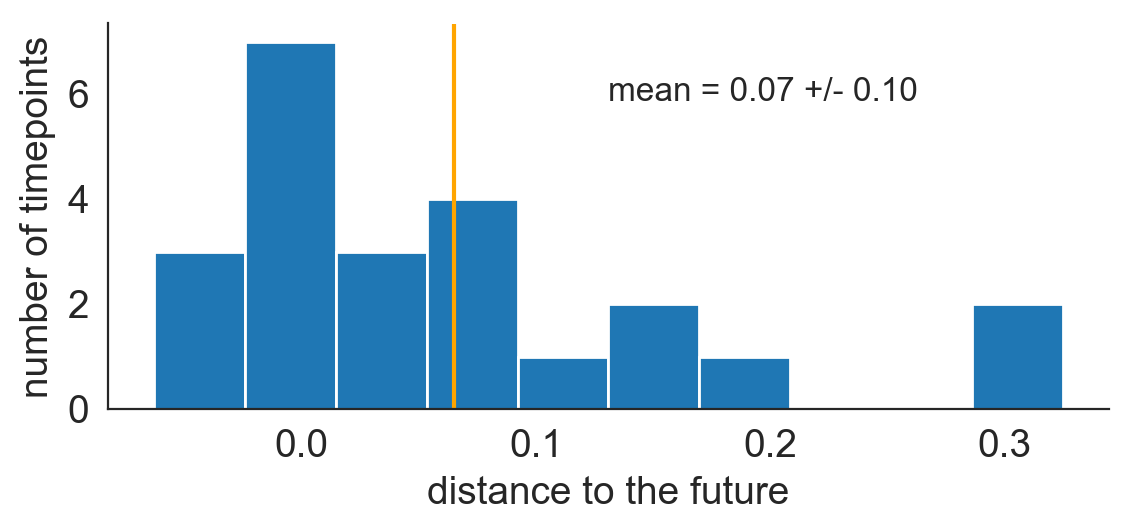

In [24]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[simulated_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_simulated_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

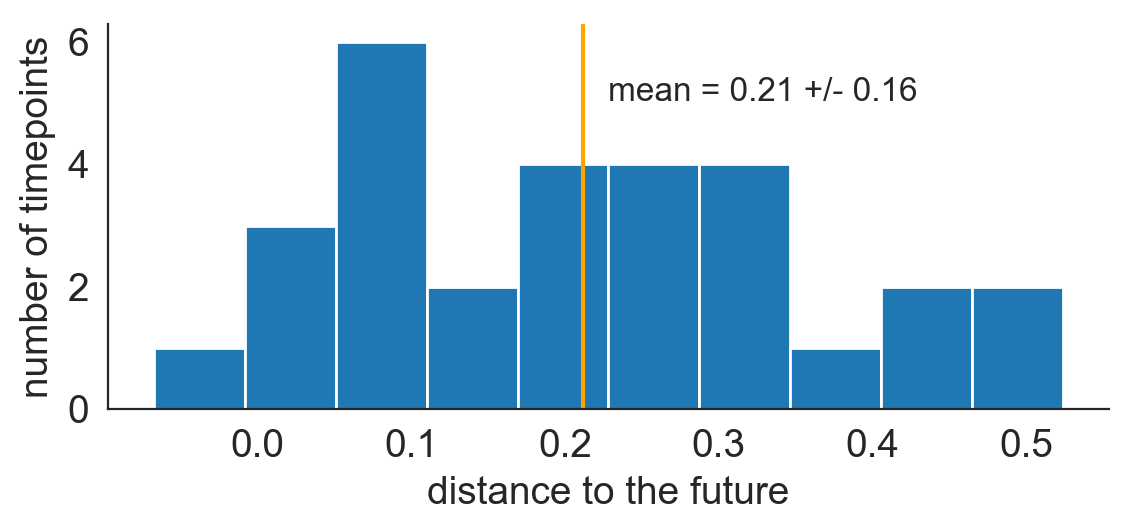

In [25]:
naive_natural_errors_by_time_df = natural_errors_by_time_df[natural_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_natural_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [26]:
total_simulated_timepoints = simulated_errors_by_time_df.loc[
    simulated_errors_by_time_df["predictors"] == "normalized_fitness",
    "validation_error"
].shape[0]
total_simulated_timepoints

23

In [27]:
true_fitness_accuracy = (
    simulated_errors_by_time_df.loc[simulated_errors_by_time_df["predictors"] == "normalized_fitness", "validation_error"] <= 0
).sum()
true_fitness_accuracy

21

In [28]:
true_fitness_accuracy / float(total_simulated_timepoints)

0.9130434782608695

In [29]:
simulated_naive_accuracy = (
    simulated_errors_by_time_df.loc[simulated_errors_by_time_df["predictors"] == "naive", "validation_error"] <= 0
).sum()
simulated_naive_accuracy

6

In [30]:
simulated_naive_accuracy / float(total_simulated_timepoints)

0.2608695652173913

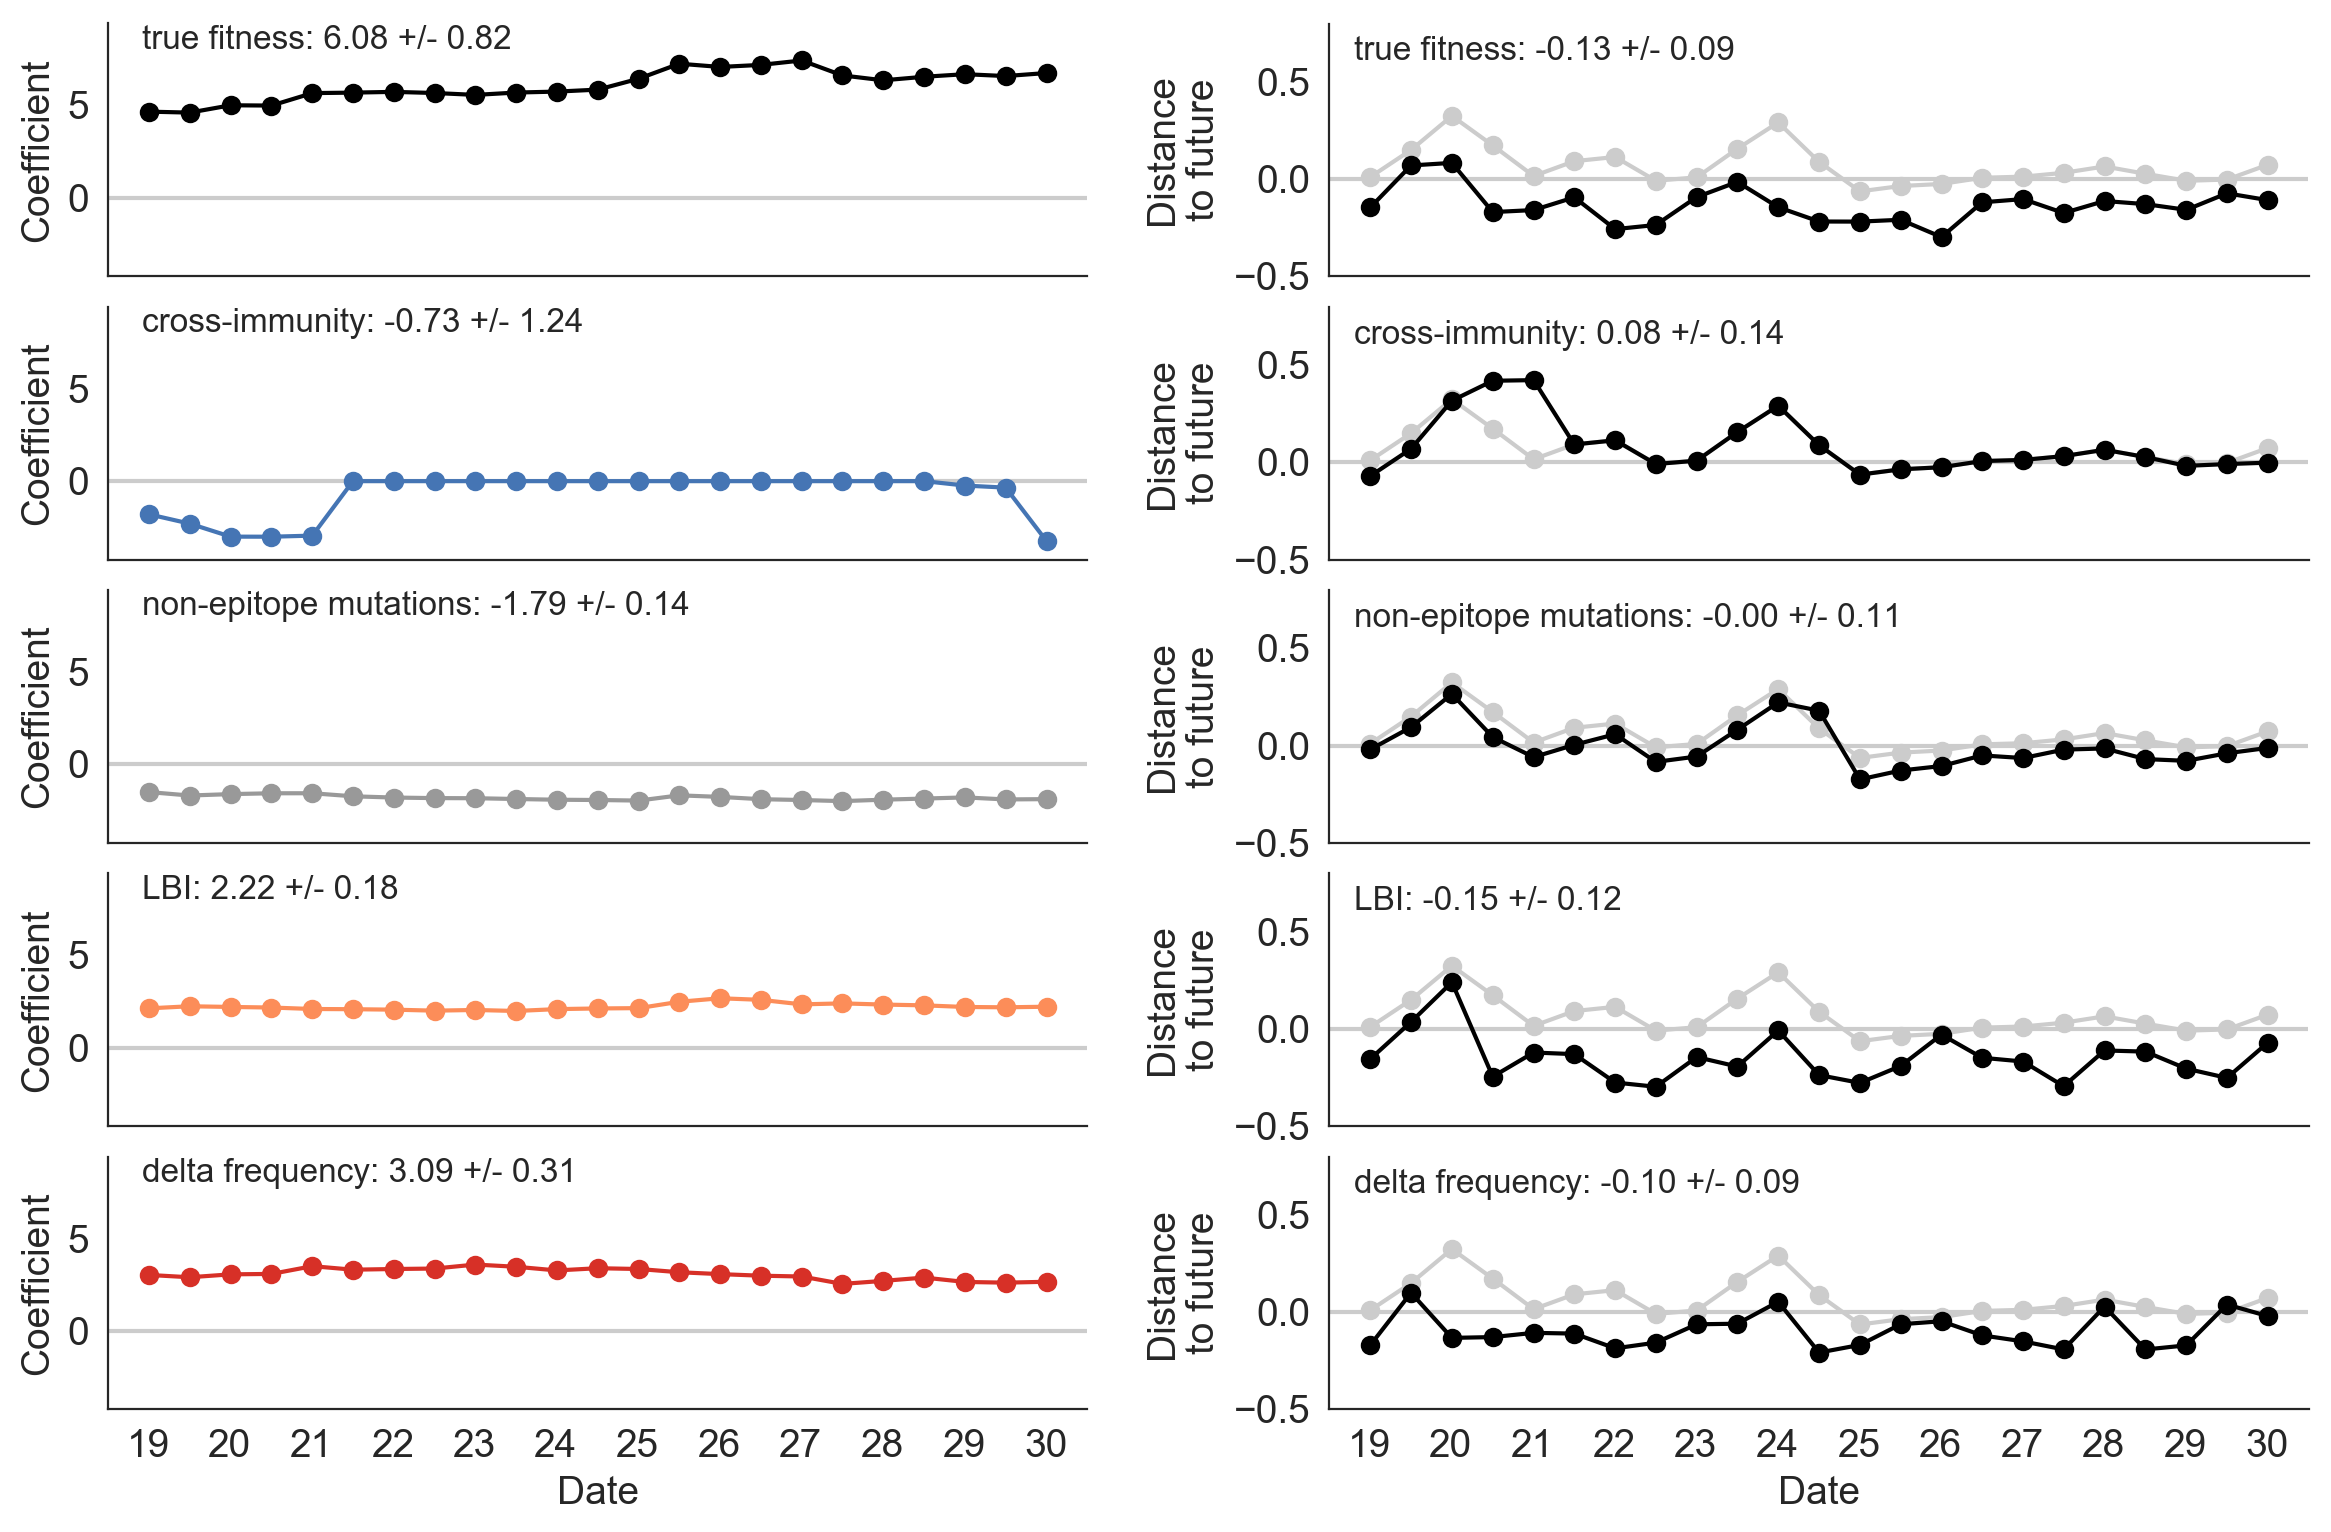

In [31]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=8,
    hspace=0.1
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

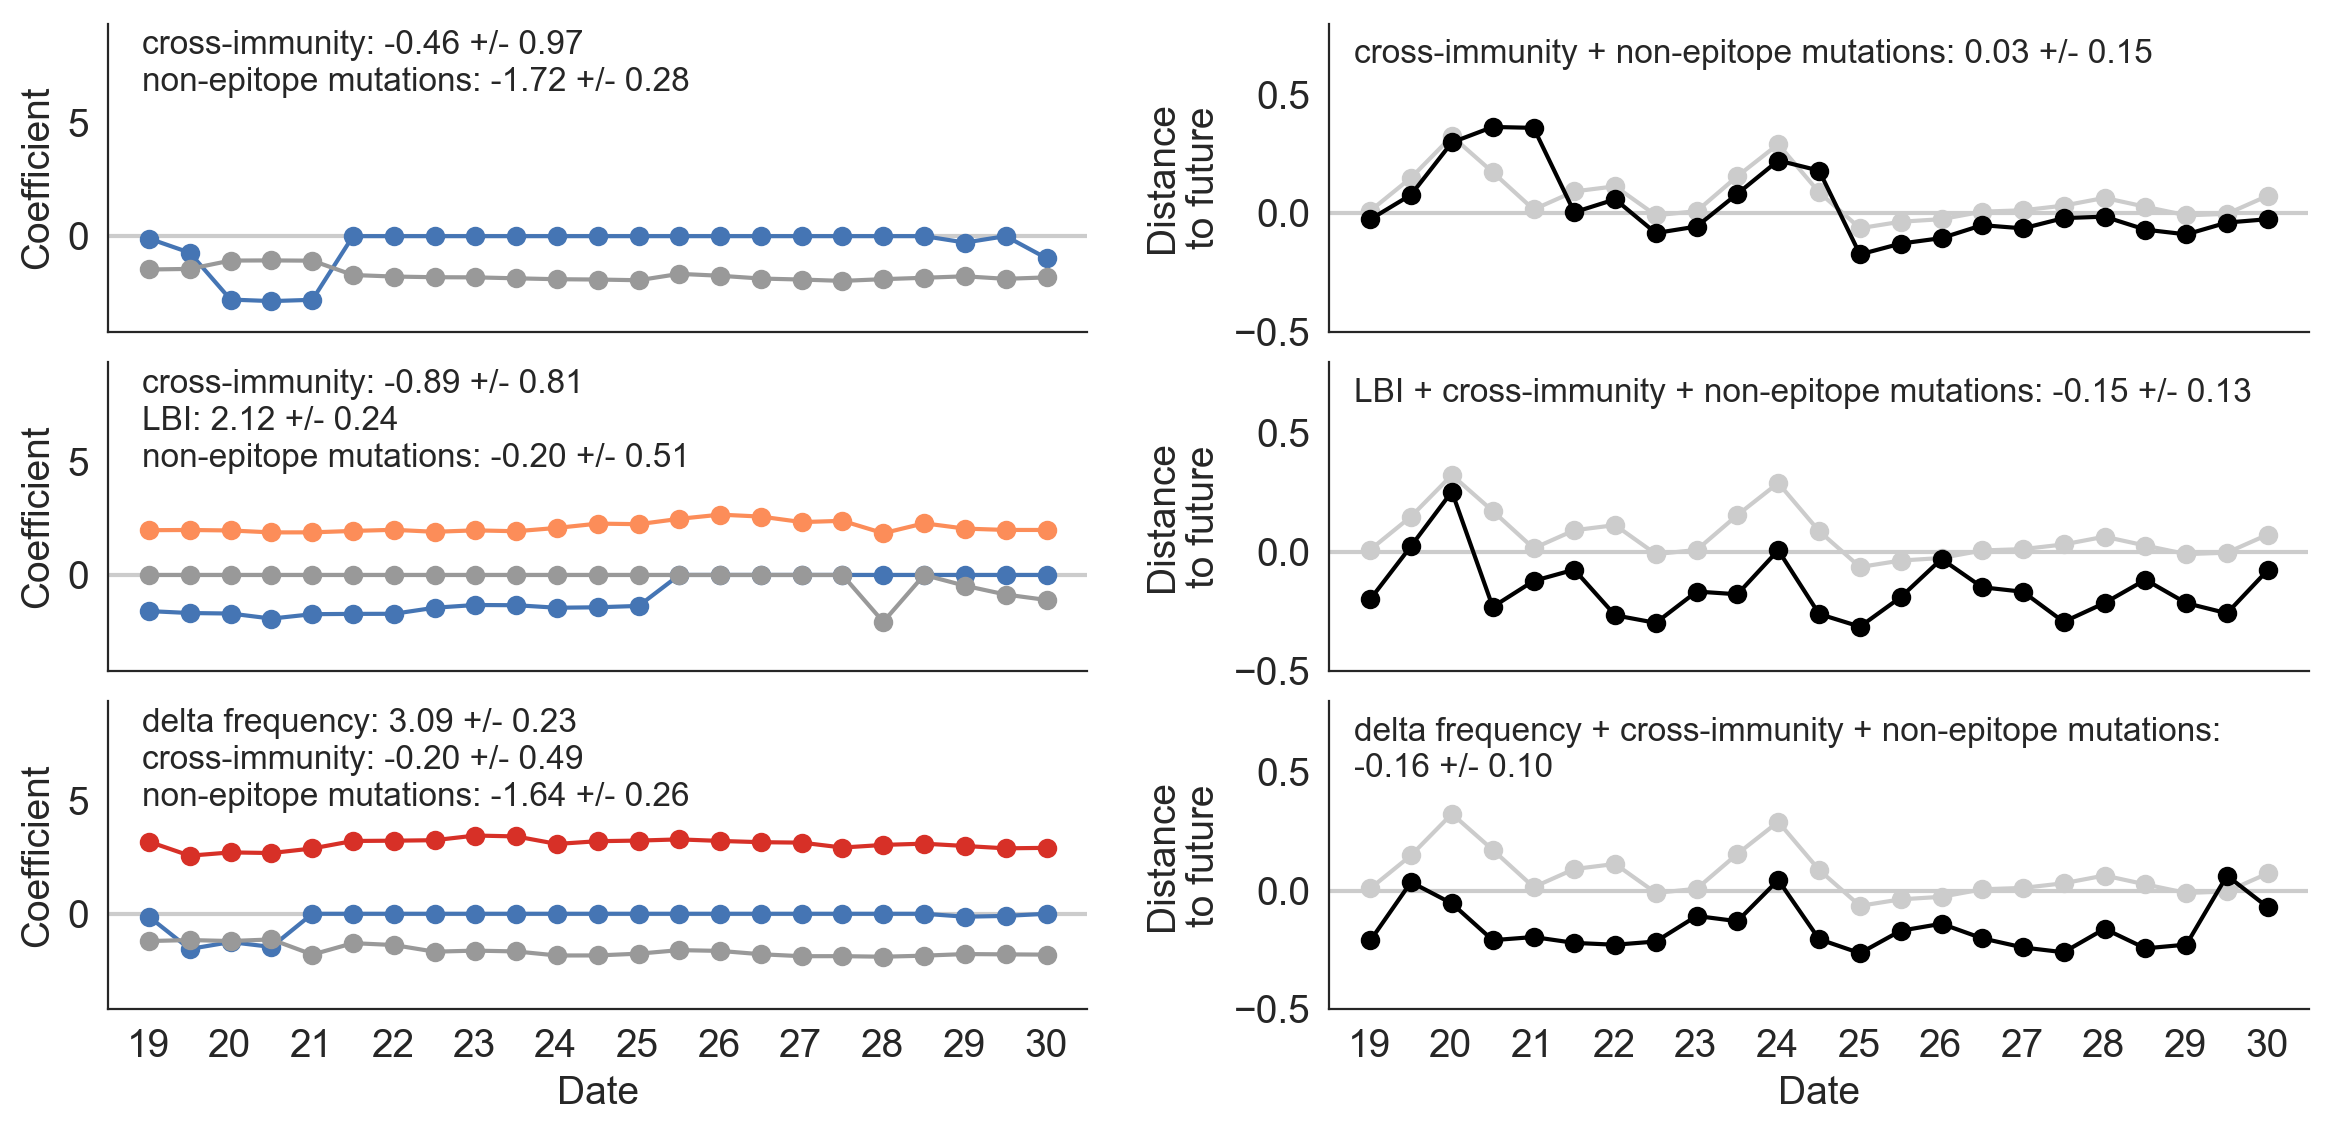

In [32]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=6
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [33]:
natural_errors_by_time_df.tail()

predictors  validation_error  validation_n  \
1043  delta_frequency-cTiter_x-ne_star          0.194044           771   
1044  delta_frequency-cTiter_x-ne_star         -0.237299           718   
1045  delta_frequency-cTiter_x-ne_star         -0.180848           683   
1046  delta_frequency-cTiter_x-ne_star          0.030620           878   
1047  delta_frequency-cTiter_x-ne_star          0.101858           976   

     validation_timepoint     type                                sample  
1043           2012-10-01  natural  natural_sample_0_with_90_vpm_sliding  
1044           2013-04-01  natural  natural_sample_0_with_90_vpm_sliding  
1045           2013-10-01  natural  natural_sample_0_with_90_vpm_sliding  
1046           2014-04-01  natural  natural_sample_0_with_90_vpm_sliding  
1047           2014-10-01  natural  natural_sample_0_with_90_vpm_sliding

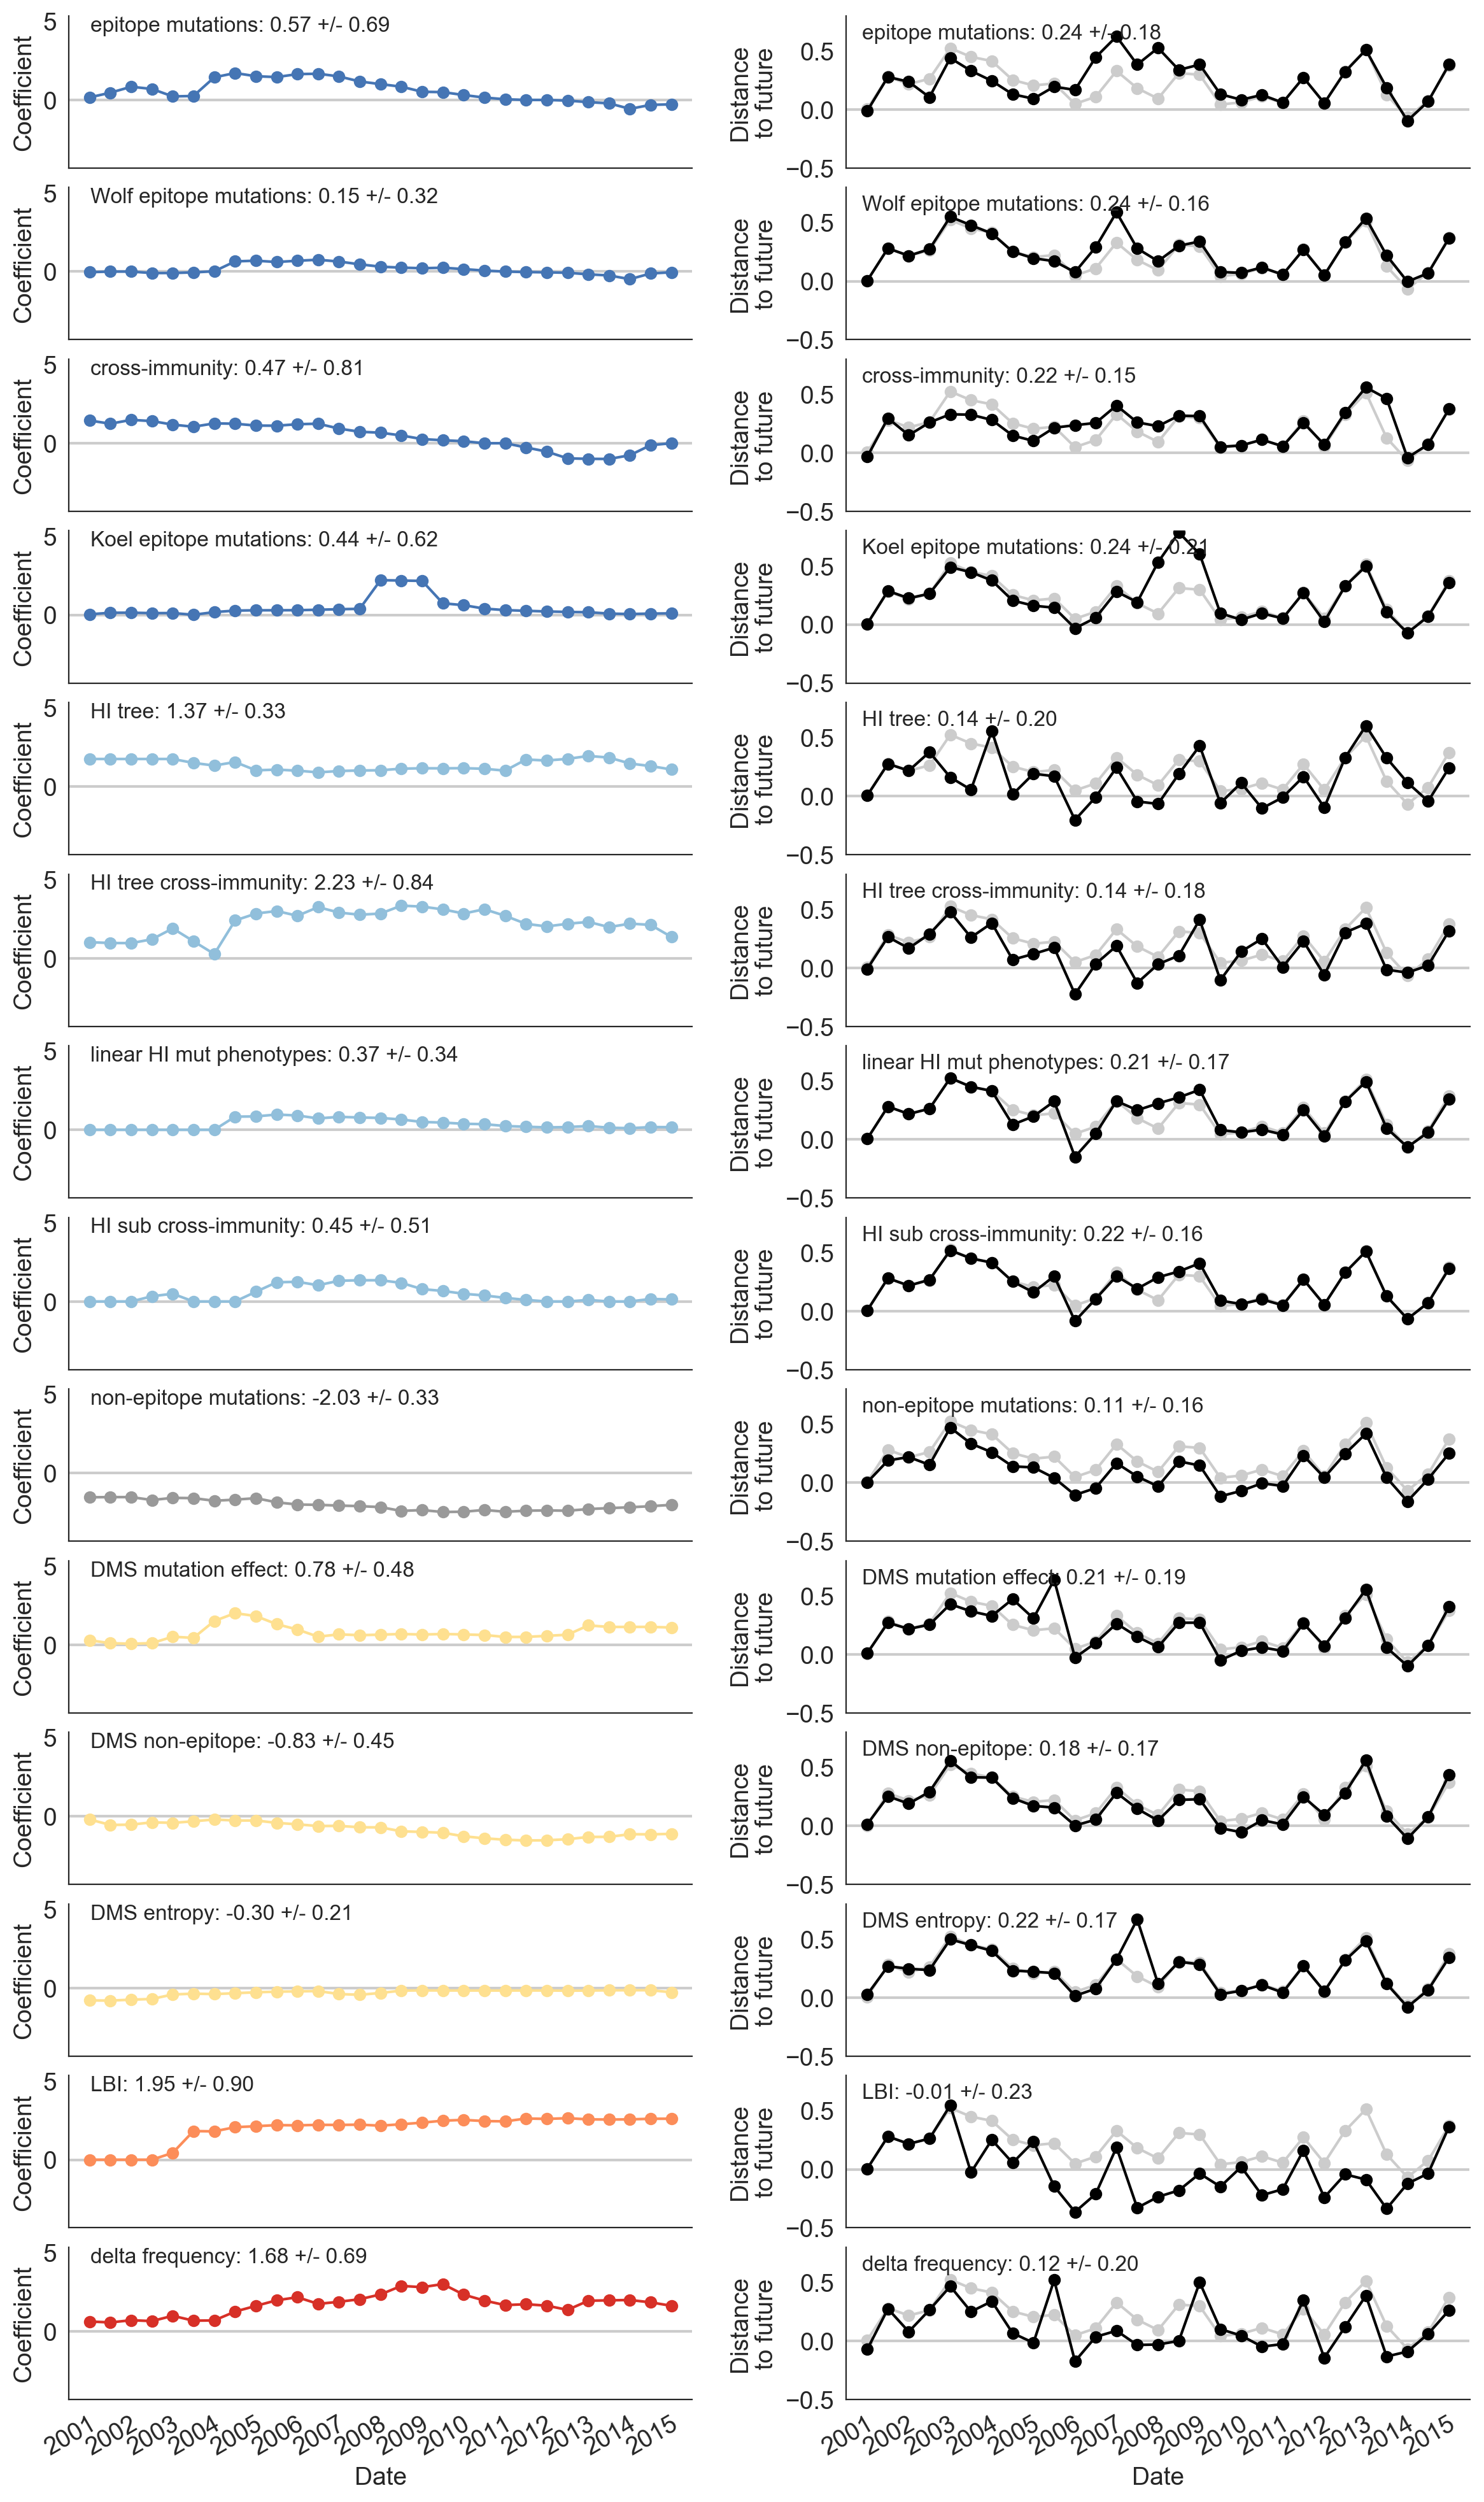

In [34]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

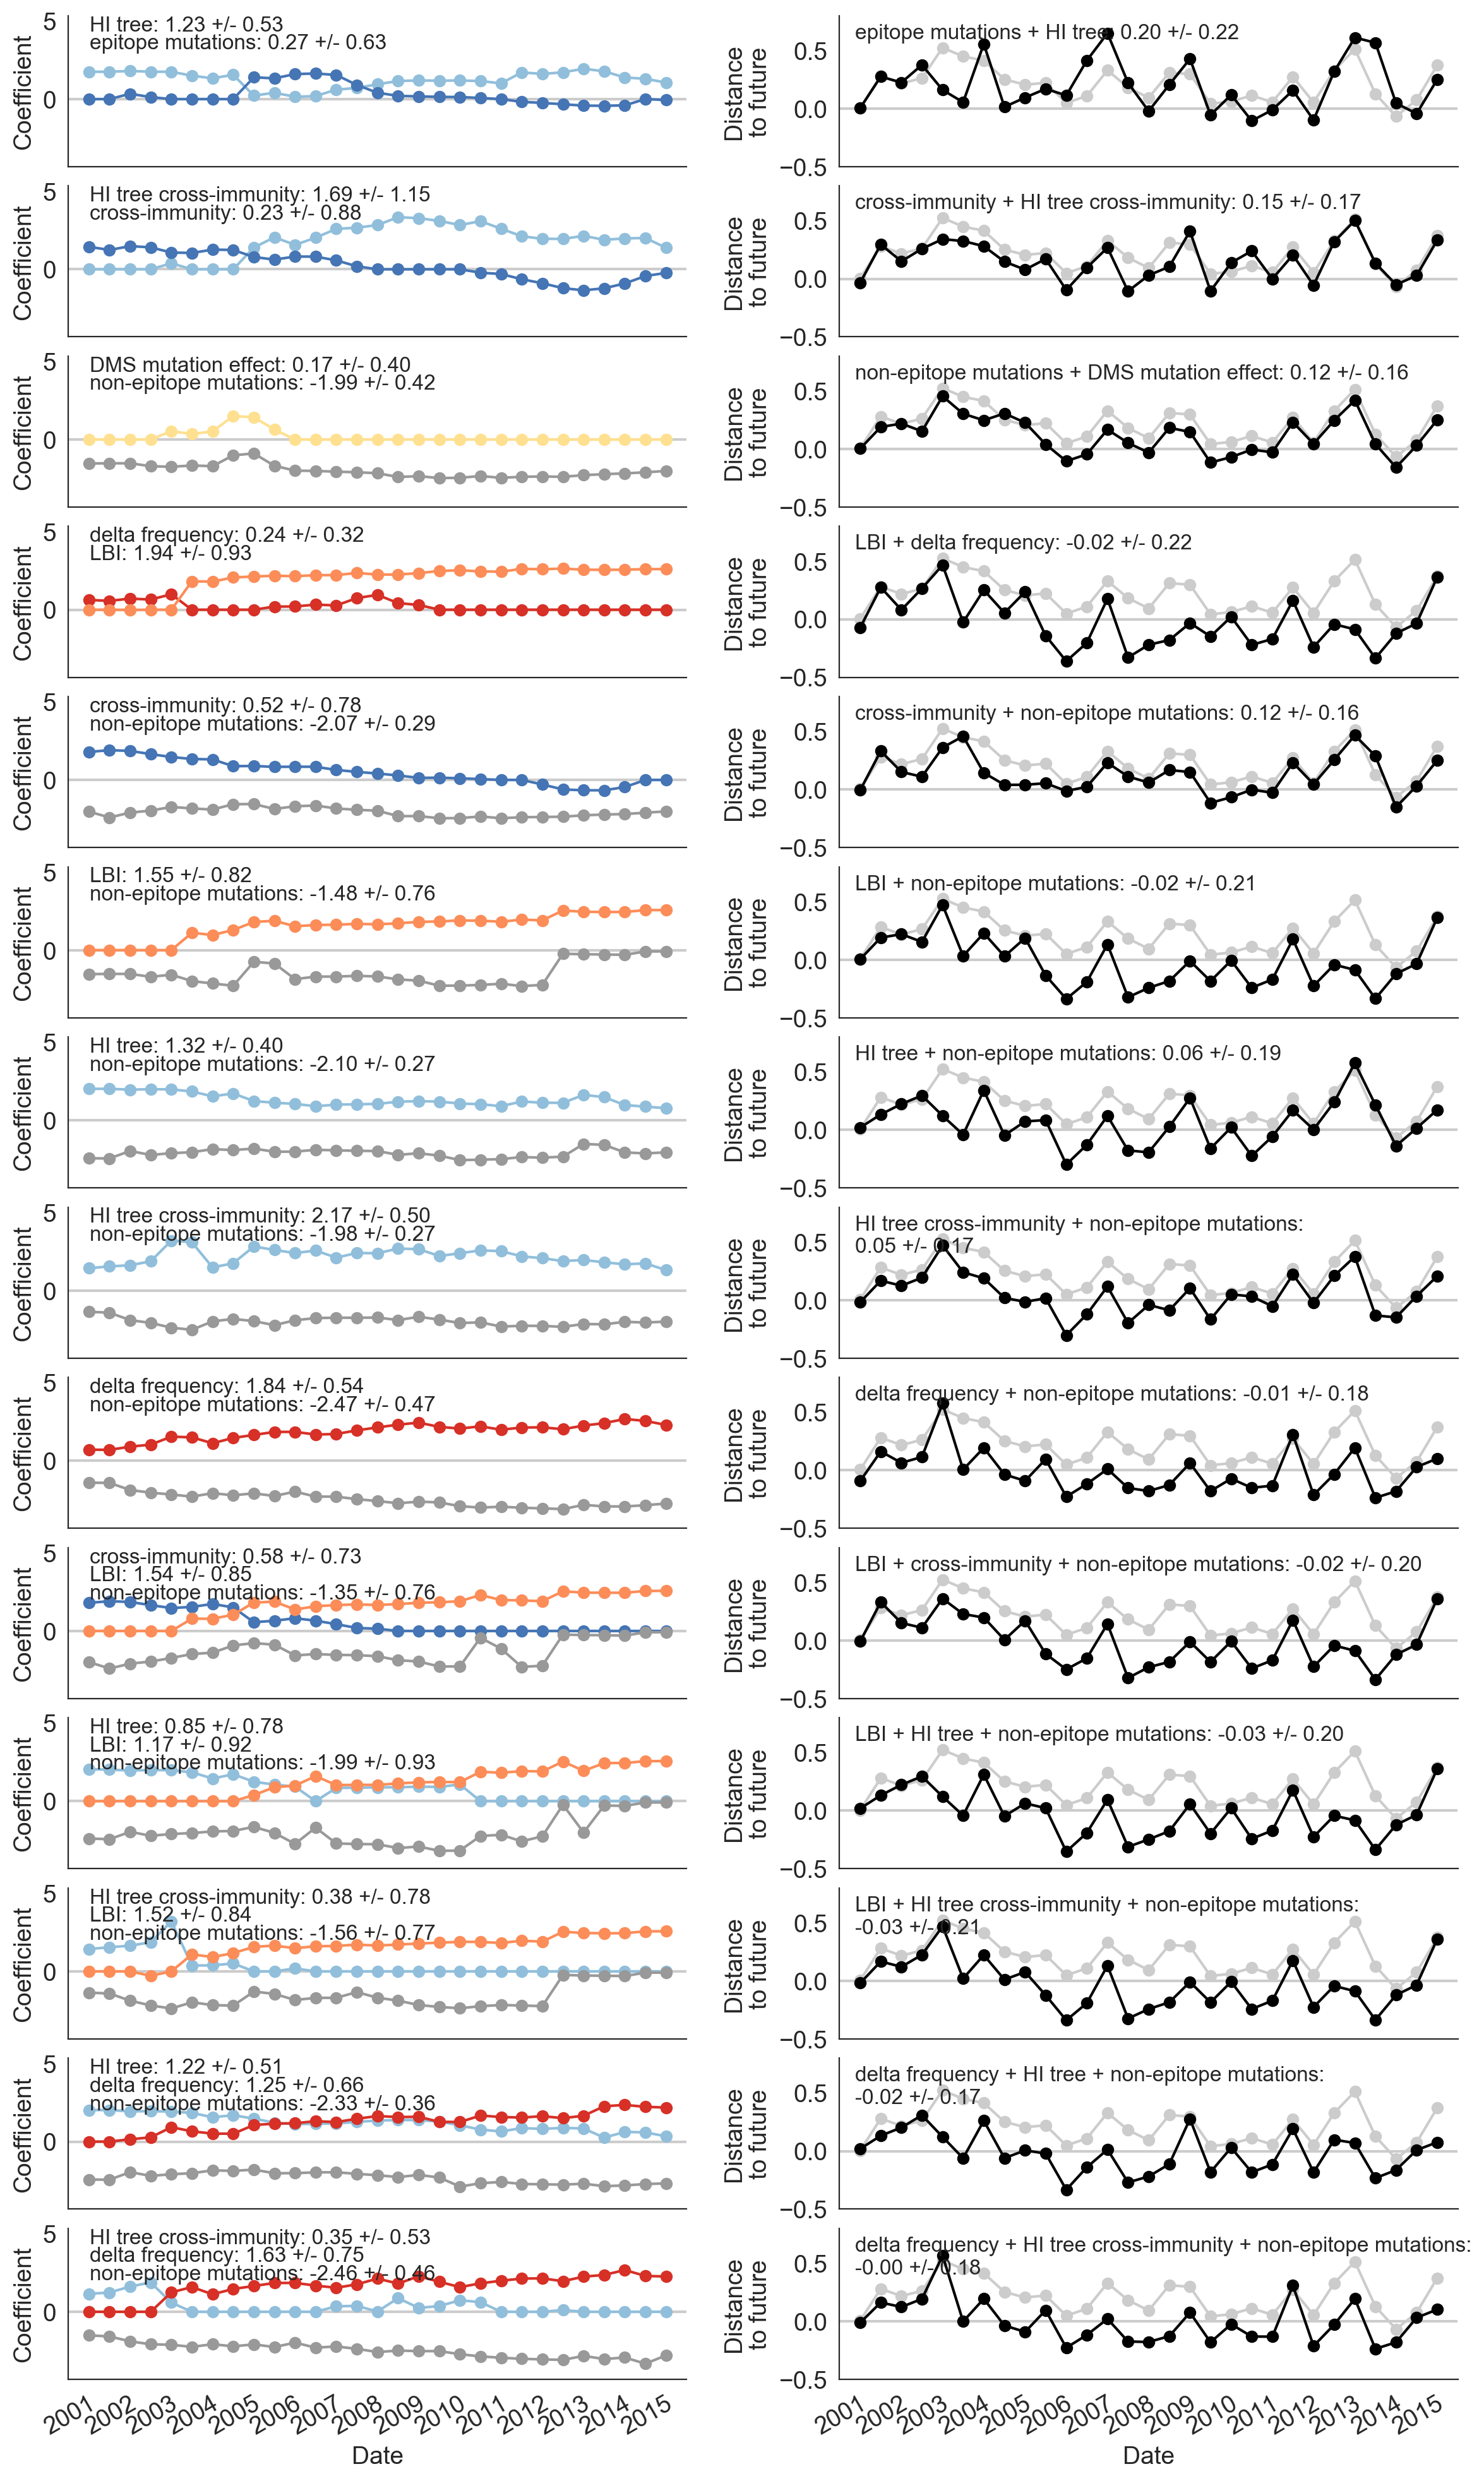

In [35]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

In [36]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

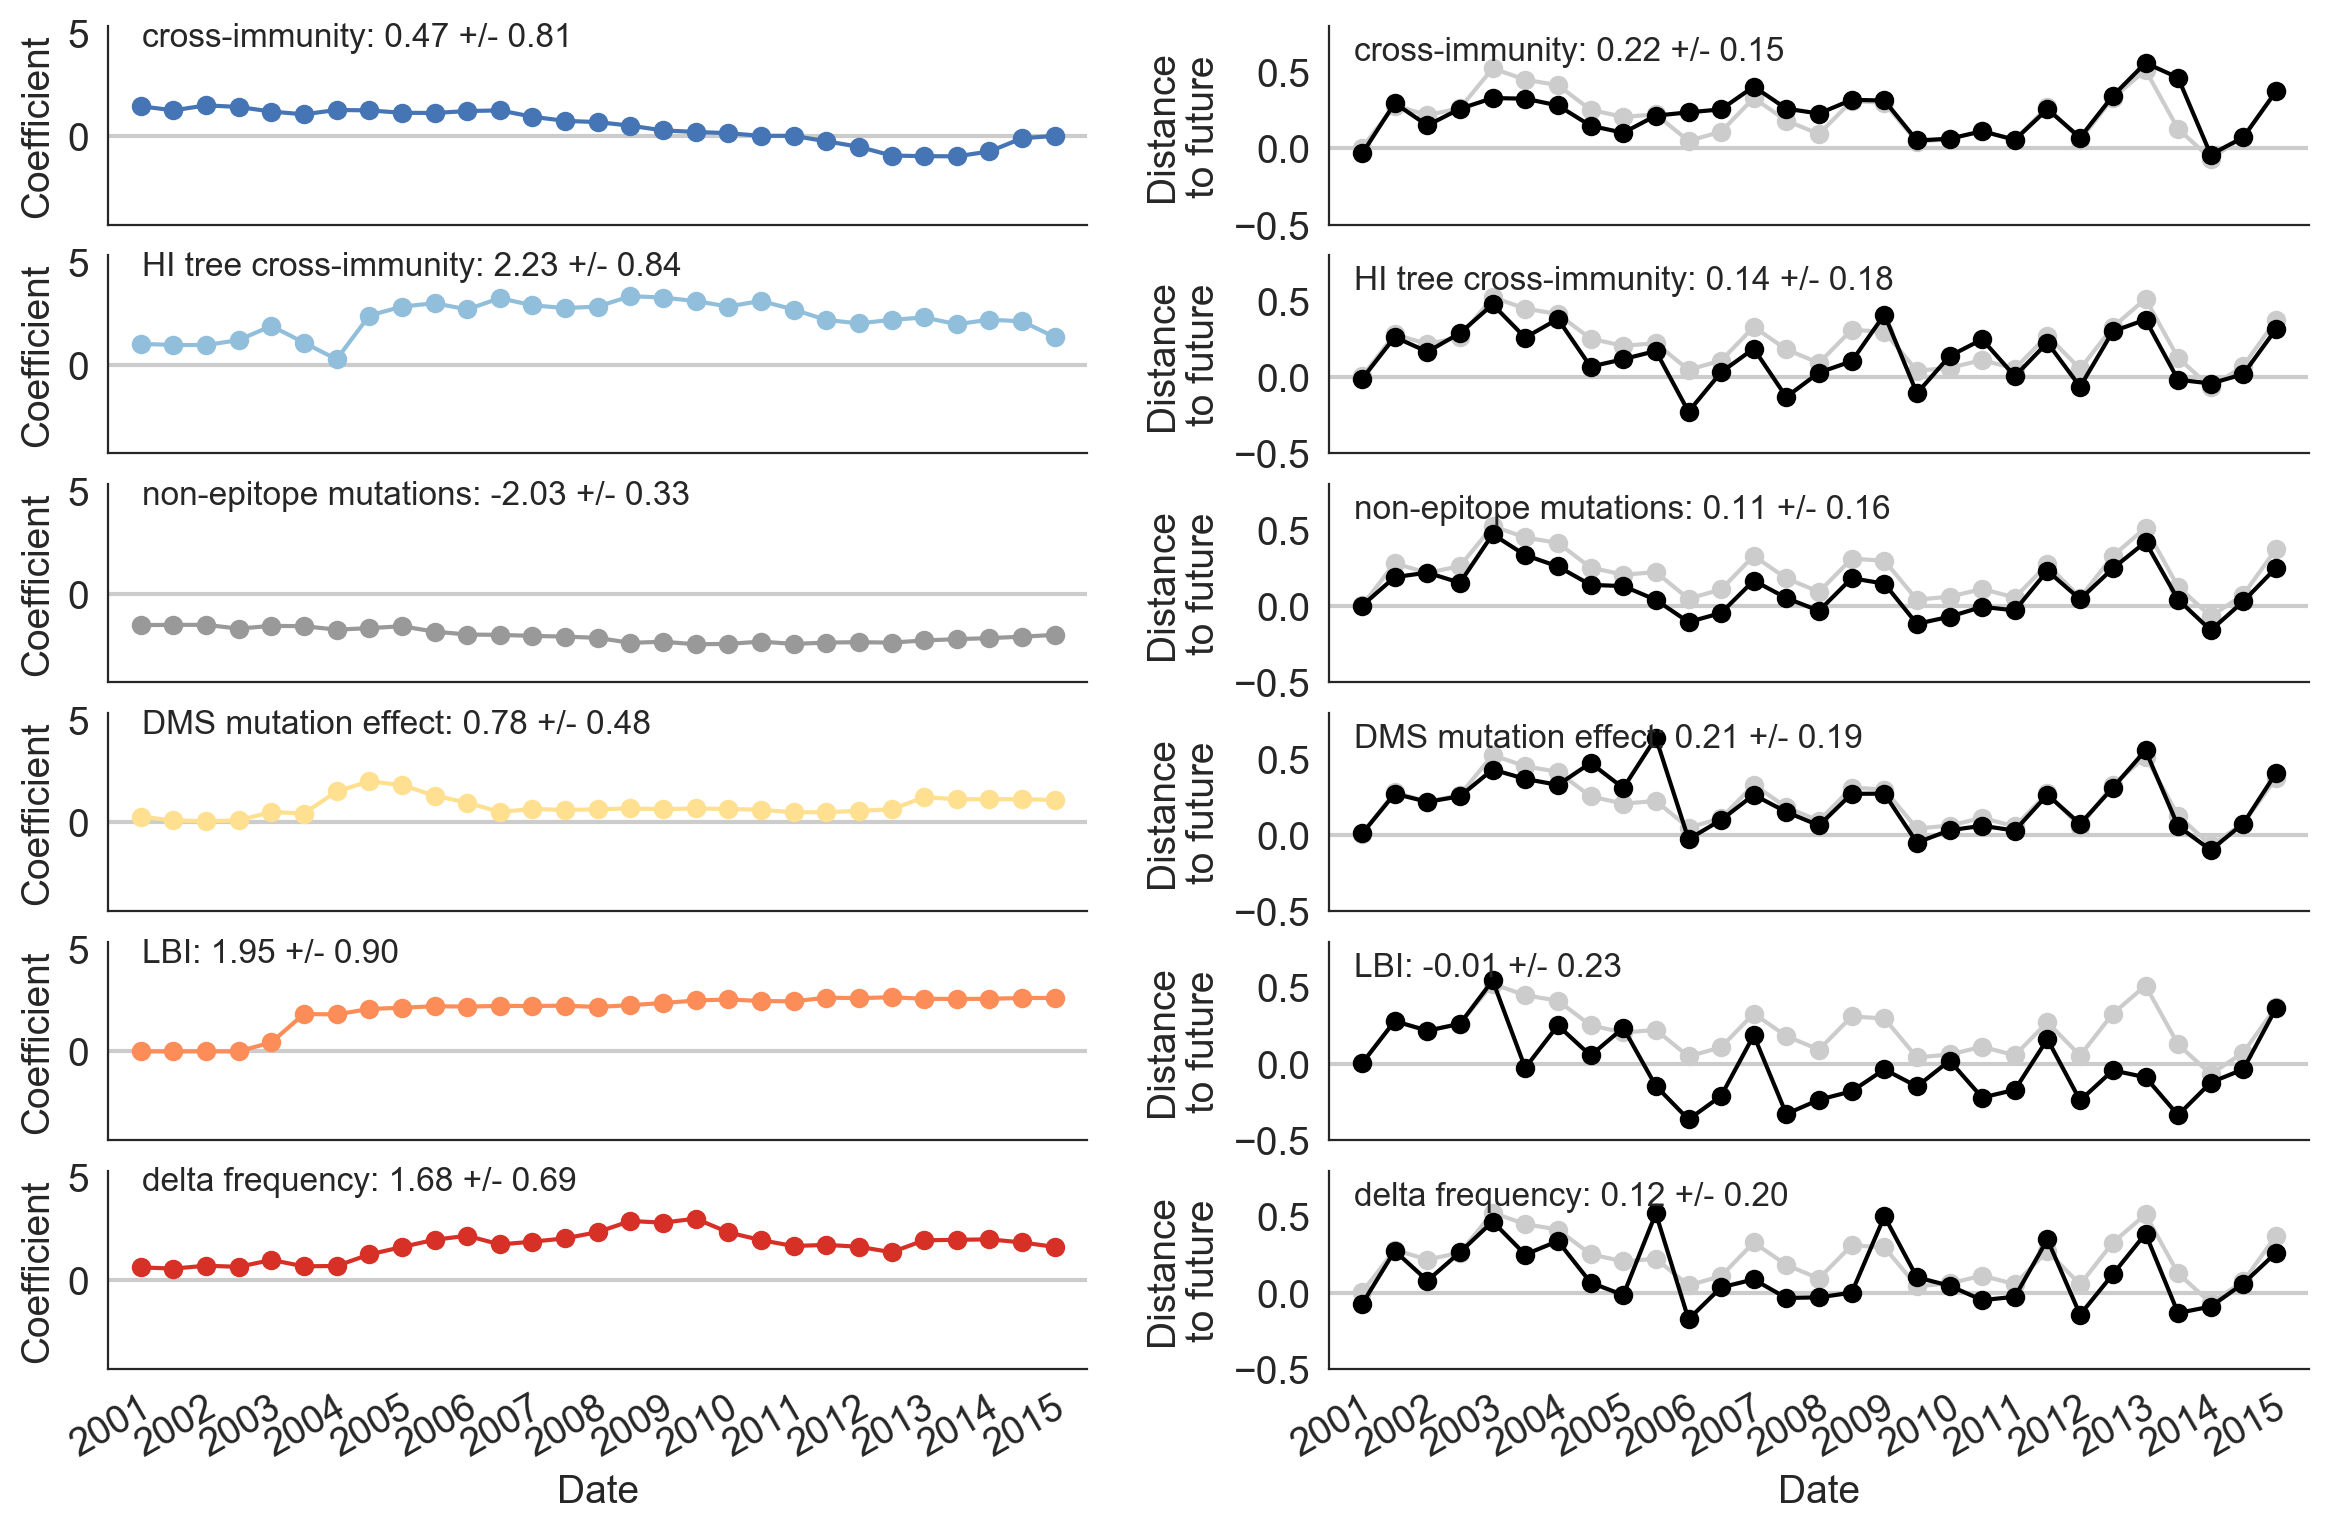

In [37]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=8
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [38]:
cross_immunity_better_than_naive = (natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "ep_x", "validation_error"
].values < natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "naive", "validation_error"
].values).sum()
cross_immunity_better_than_naive

11

In [39]:
titers_better_than_naive = (natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "cTiter_x", "validation_error"
].values < natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "naive", "validation_error"
].values).sum()
titers_better_than_naive

24

In [40]:
total_timepoints = natural_errors_by_time_df.loc[natural_errors_by_time_df["predictors"] == "cTiter_x", "validation_error"].values.shape[0]

In [41]:
total_timepoints

29

In [42]:
titers_better_than_naive / float(total_timepoints)

0.8275862068965517

In [43]:
cross_immunity_better_than_naive / float(total_timepoints)

0.3793103448275862

### Within category model comparisons

#### Antigenic

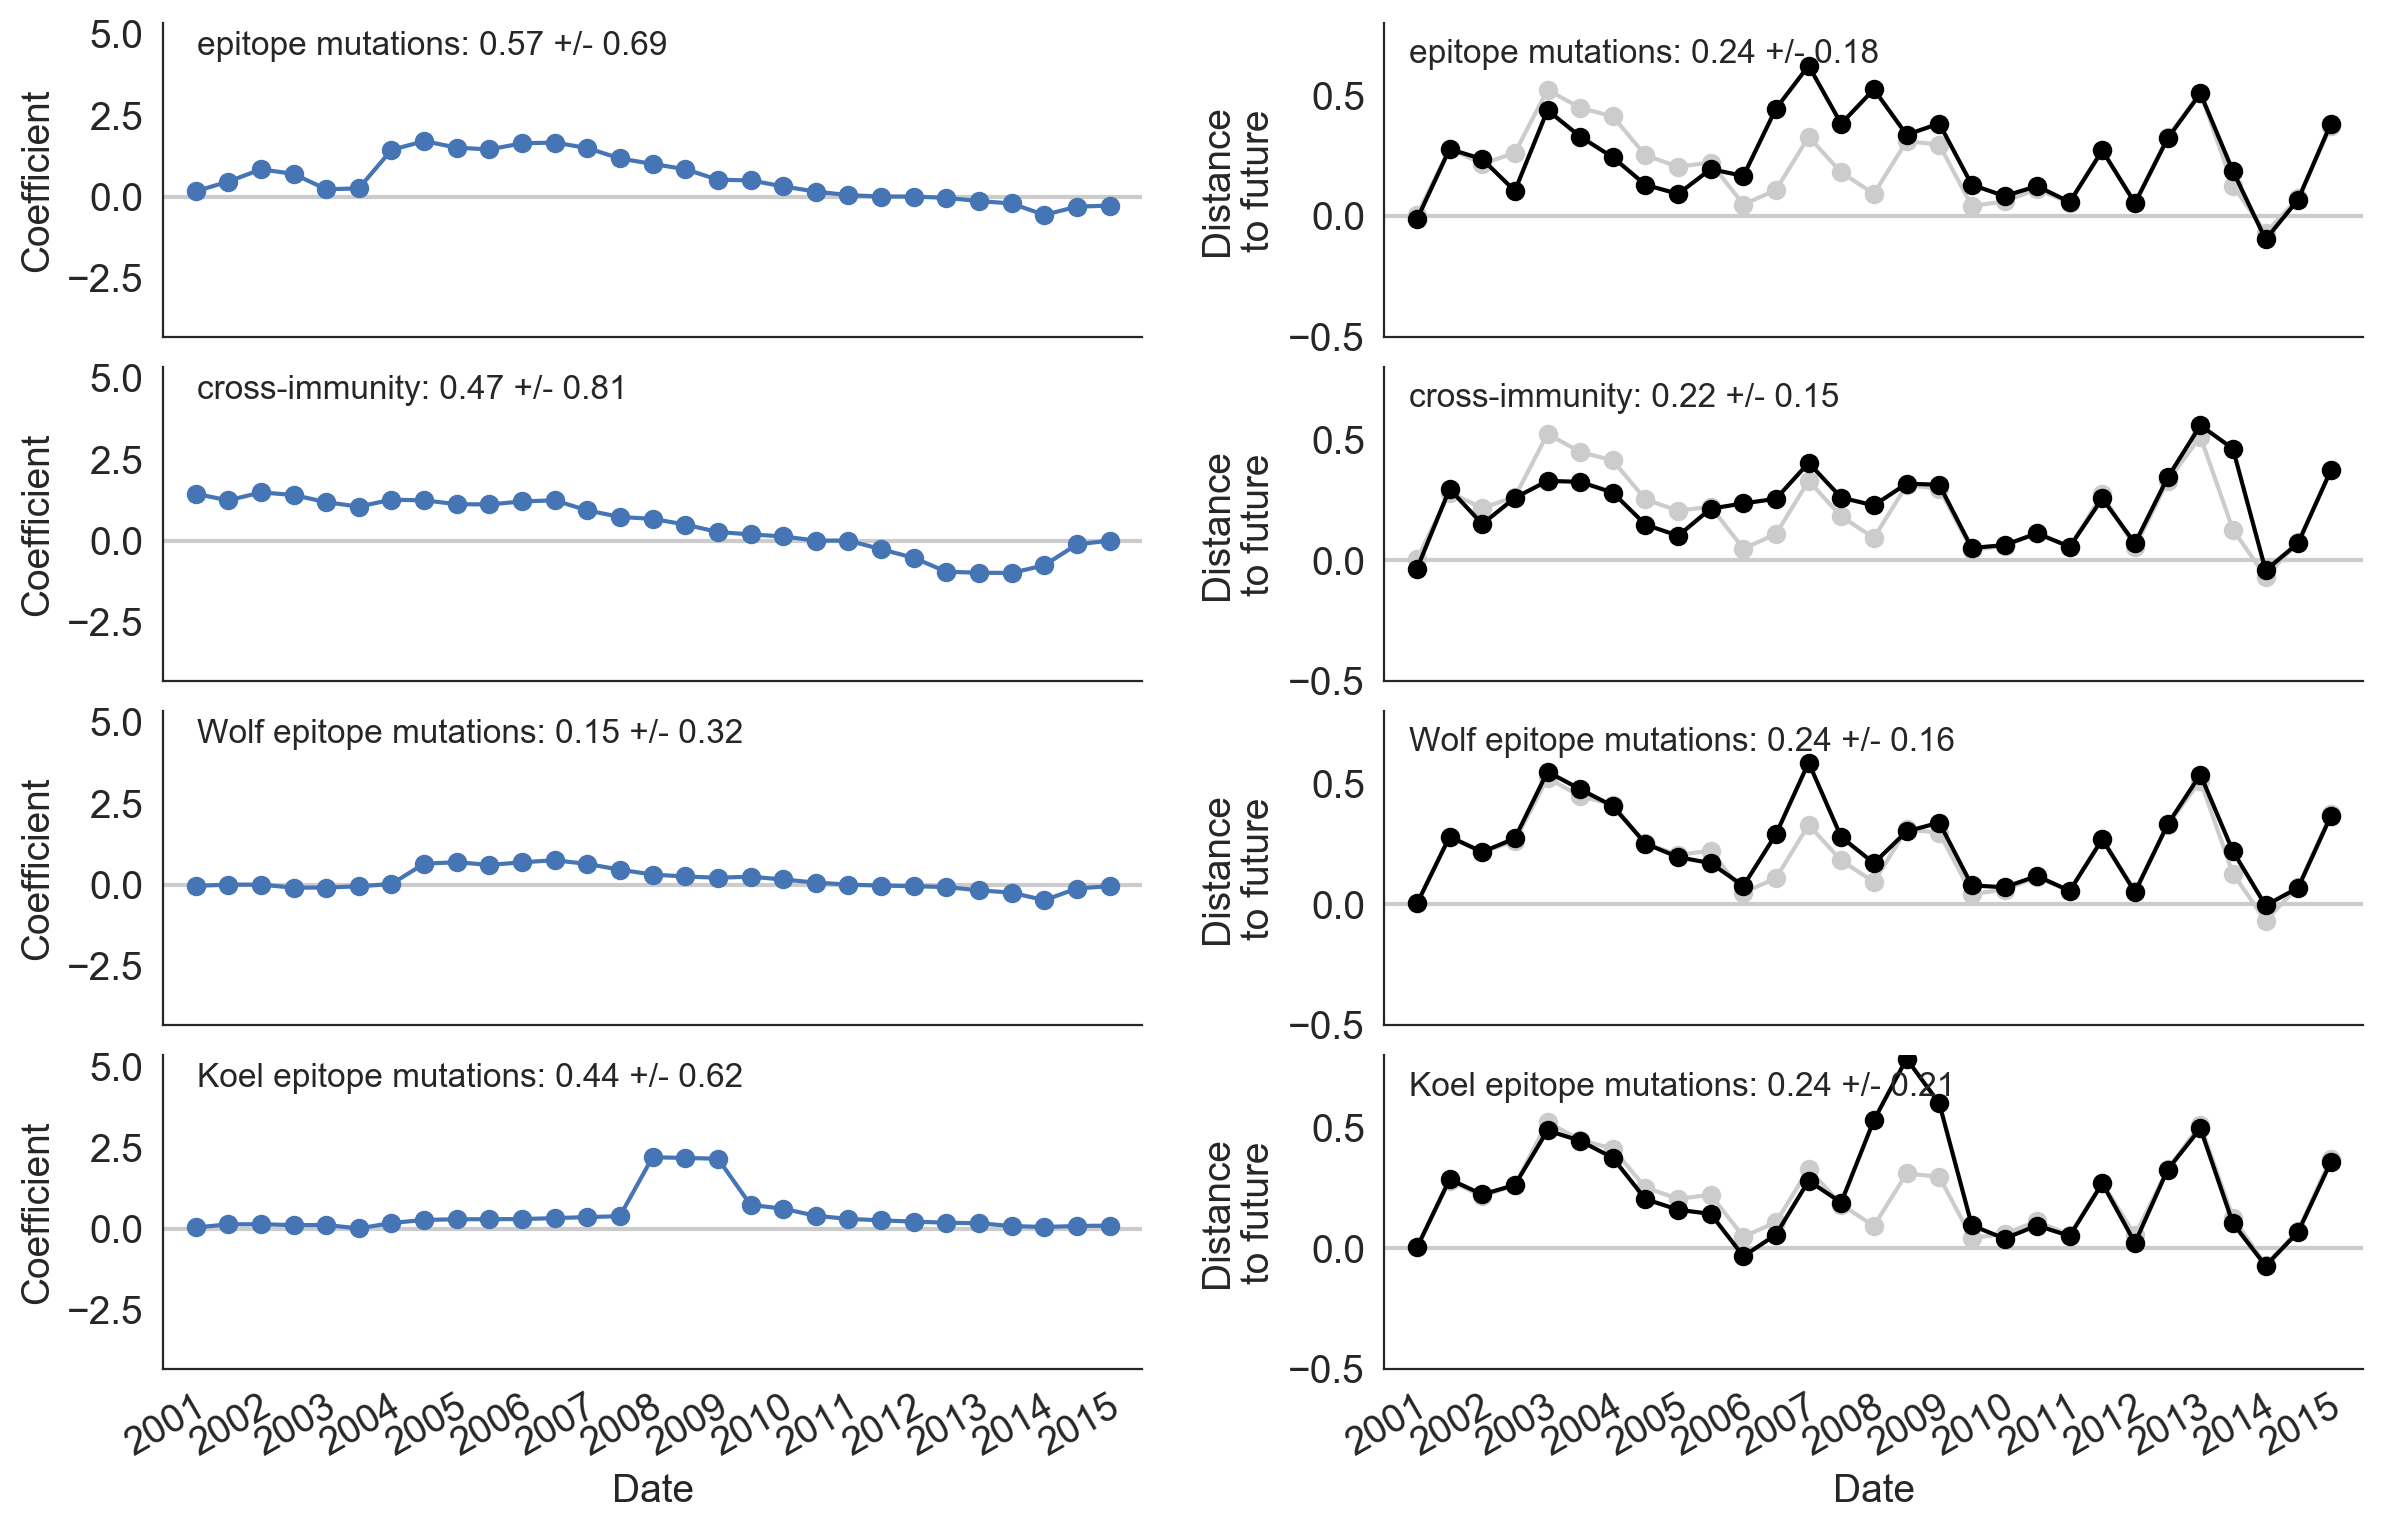

In [44]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8
)
plt.savefig("../manuscript/figures/unadjusted-epitope-model-accuracy-and-coefficients-for-natural-populations.png")

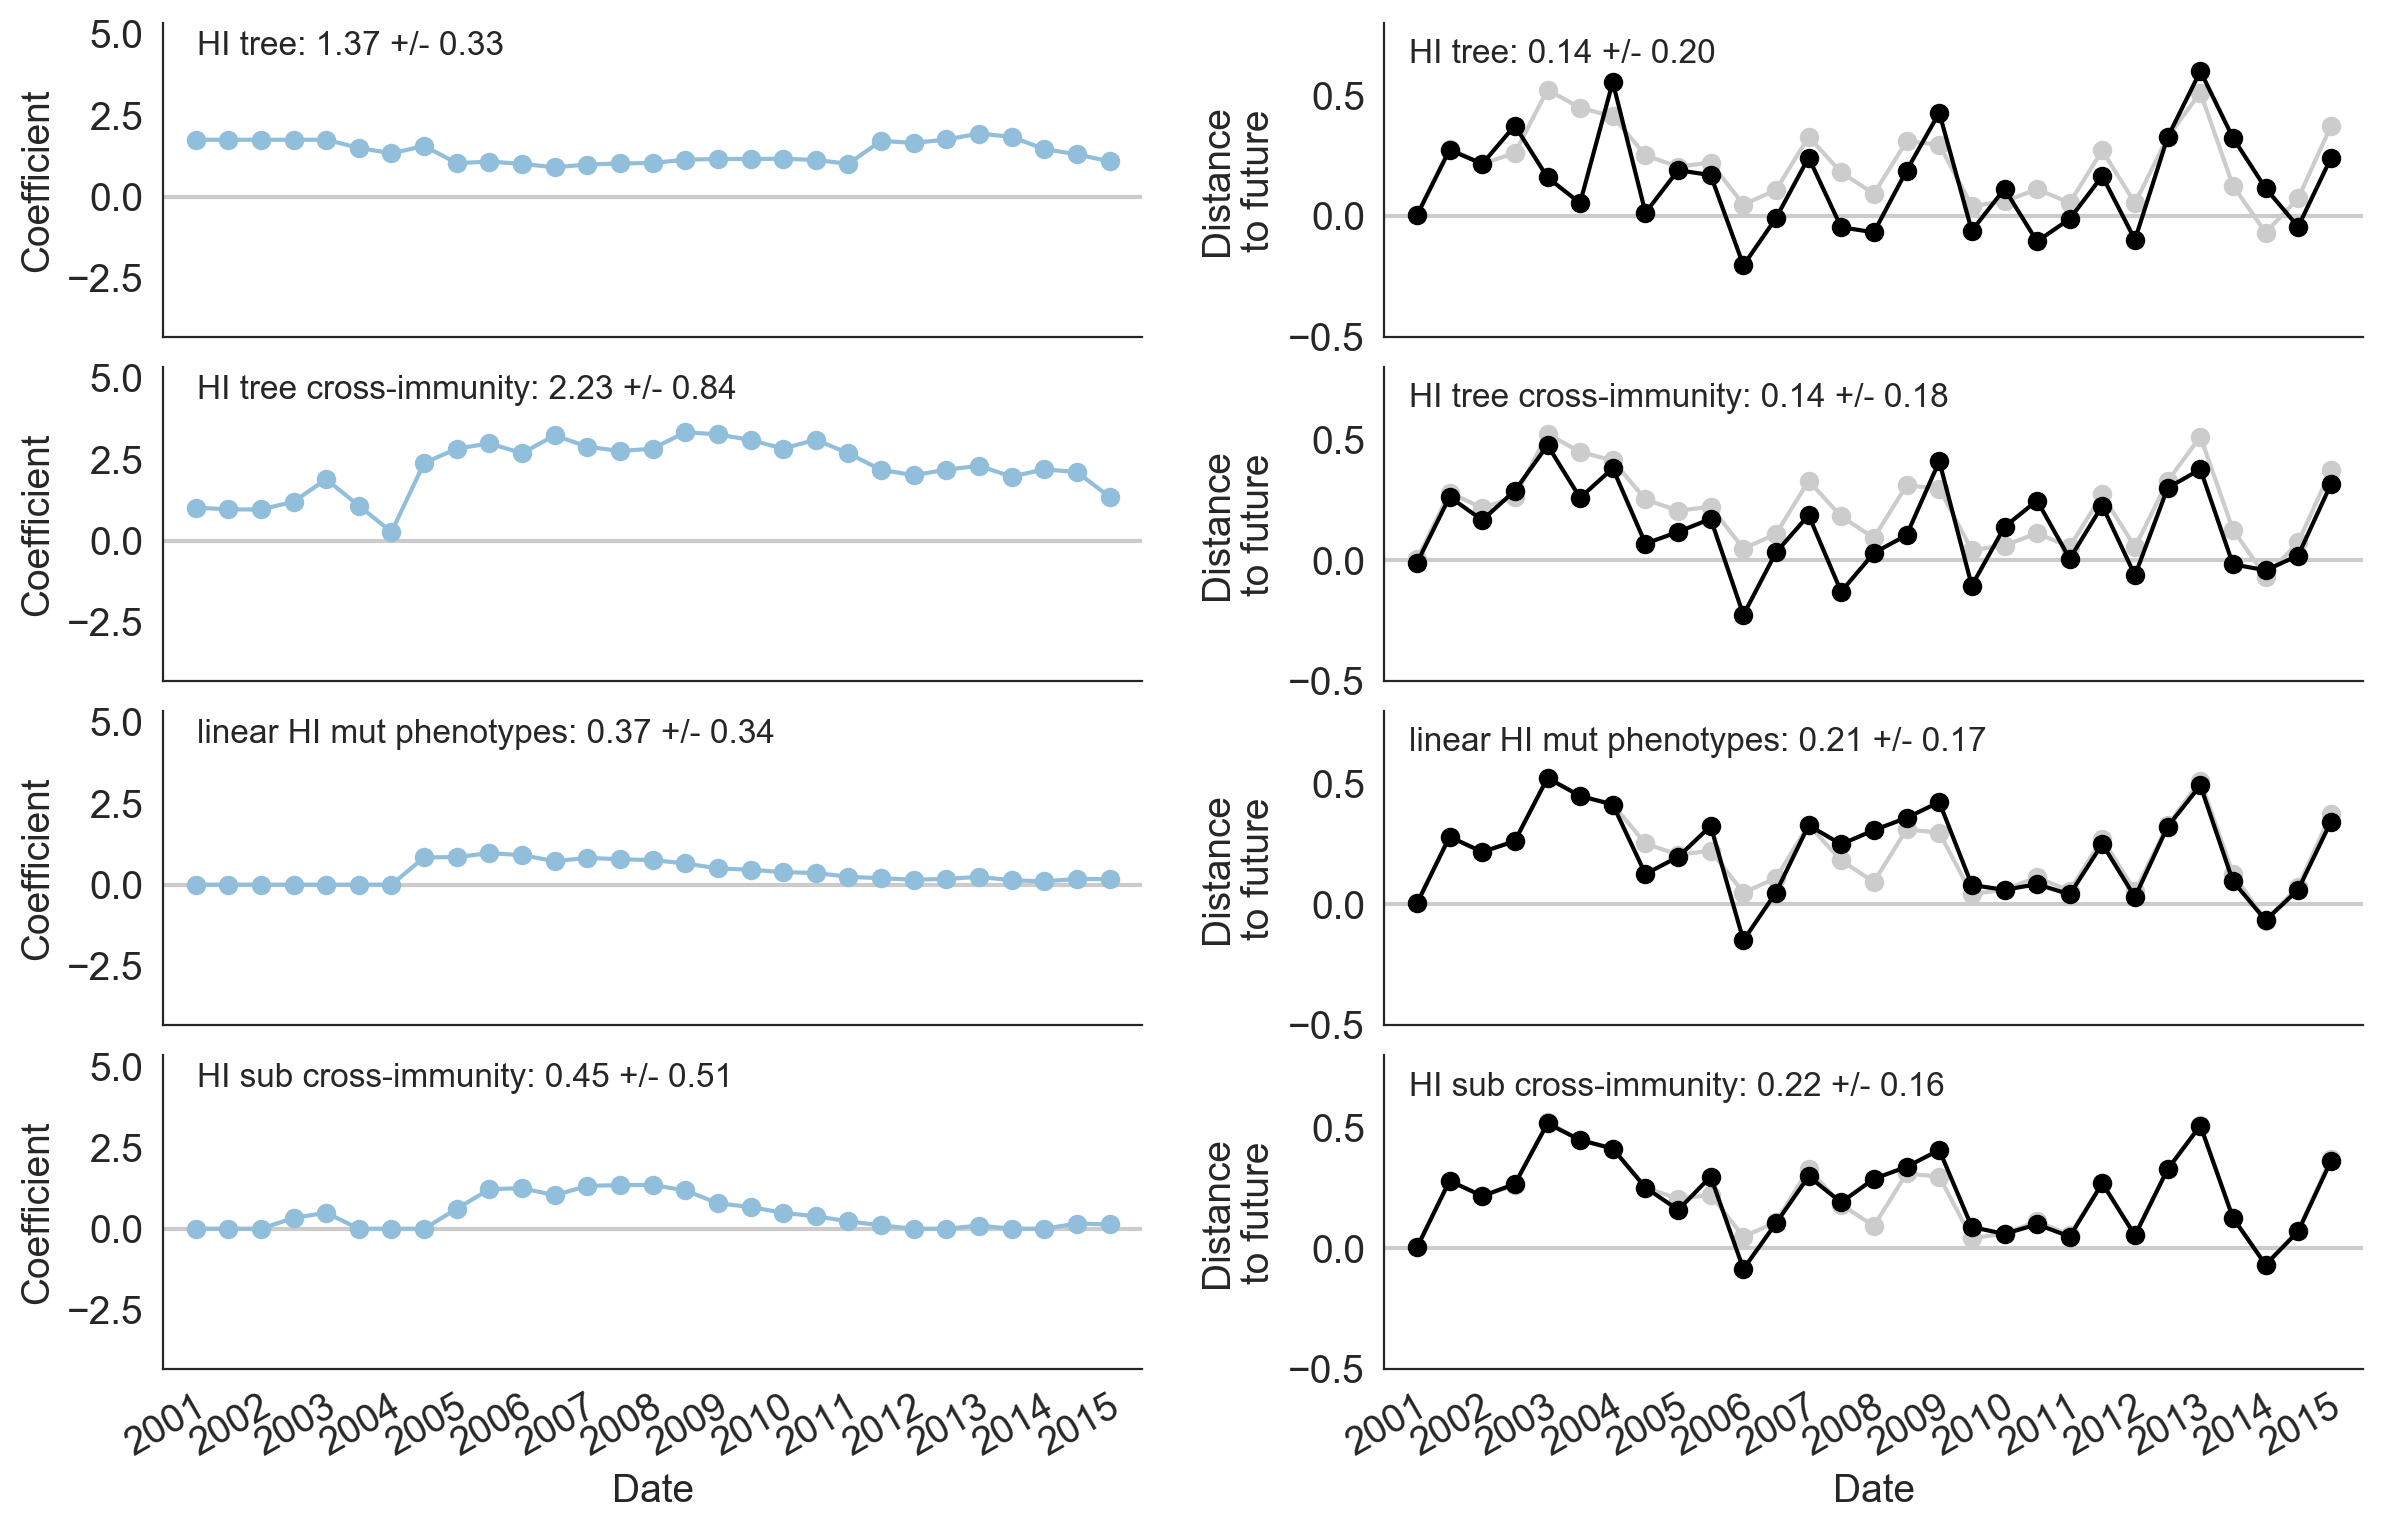

In [45]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8
)
plt.savefig("../manuscript/figures/unadjusted-HI-model-accuracy-and-coefficients-for-natural-populations.png")

#### Functional

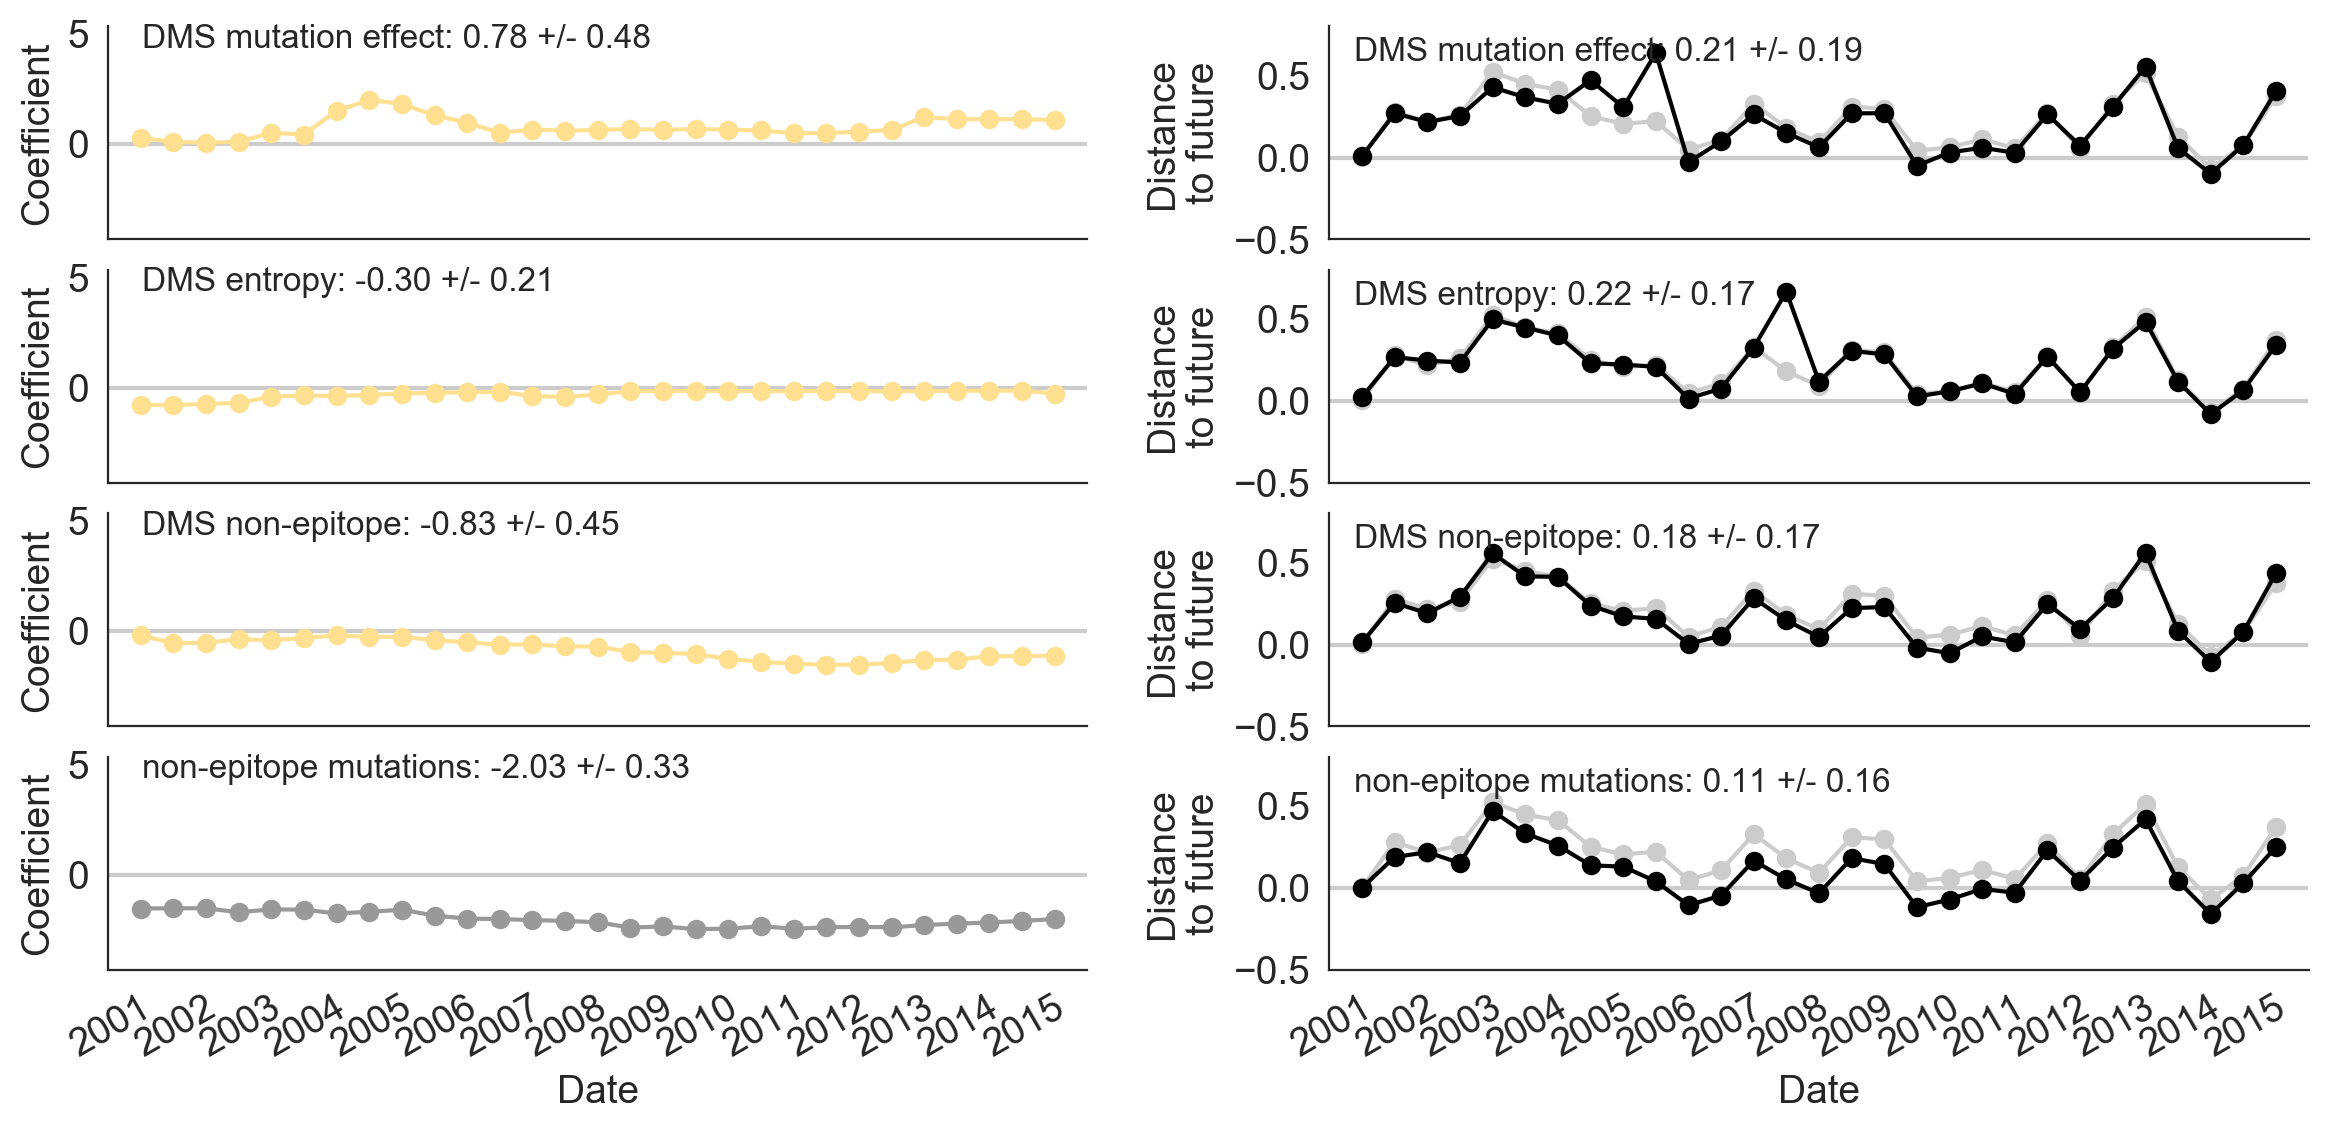

In [46]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=6
)
plt.savefig("../manuscript/figures/unadjusted-DMS-model-accuracy-and-coefficients-for-natural-populations.png")

#### All categories

In [47]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

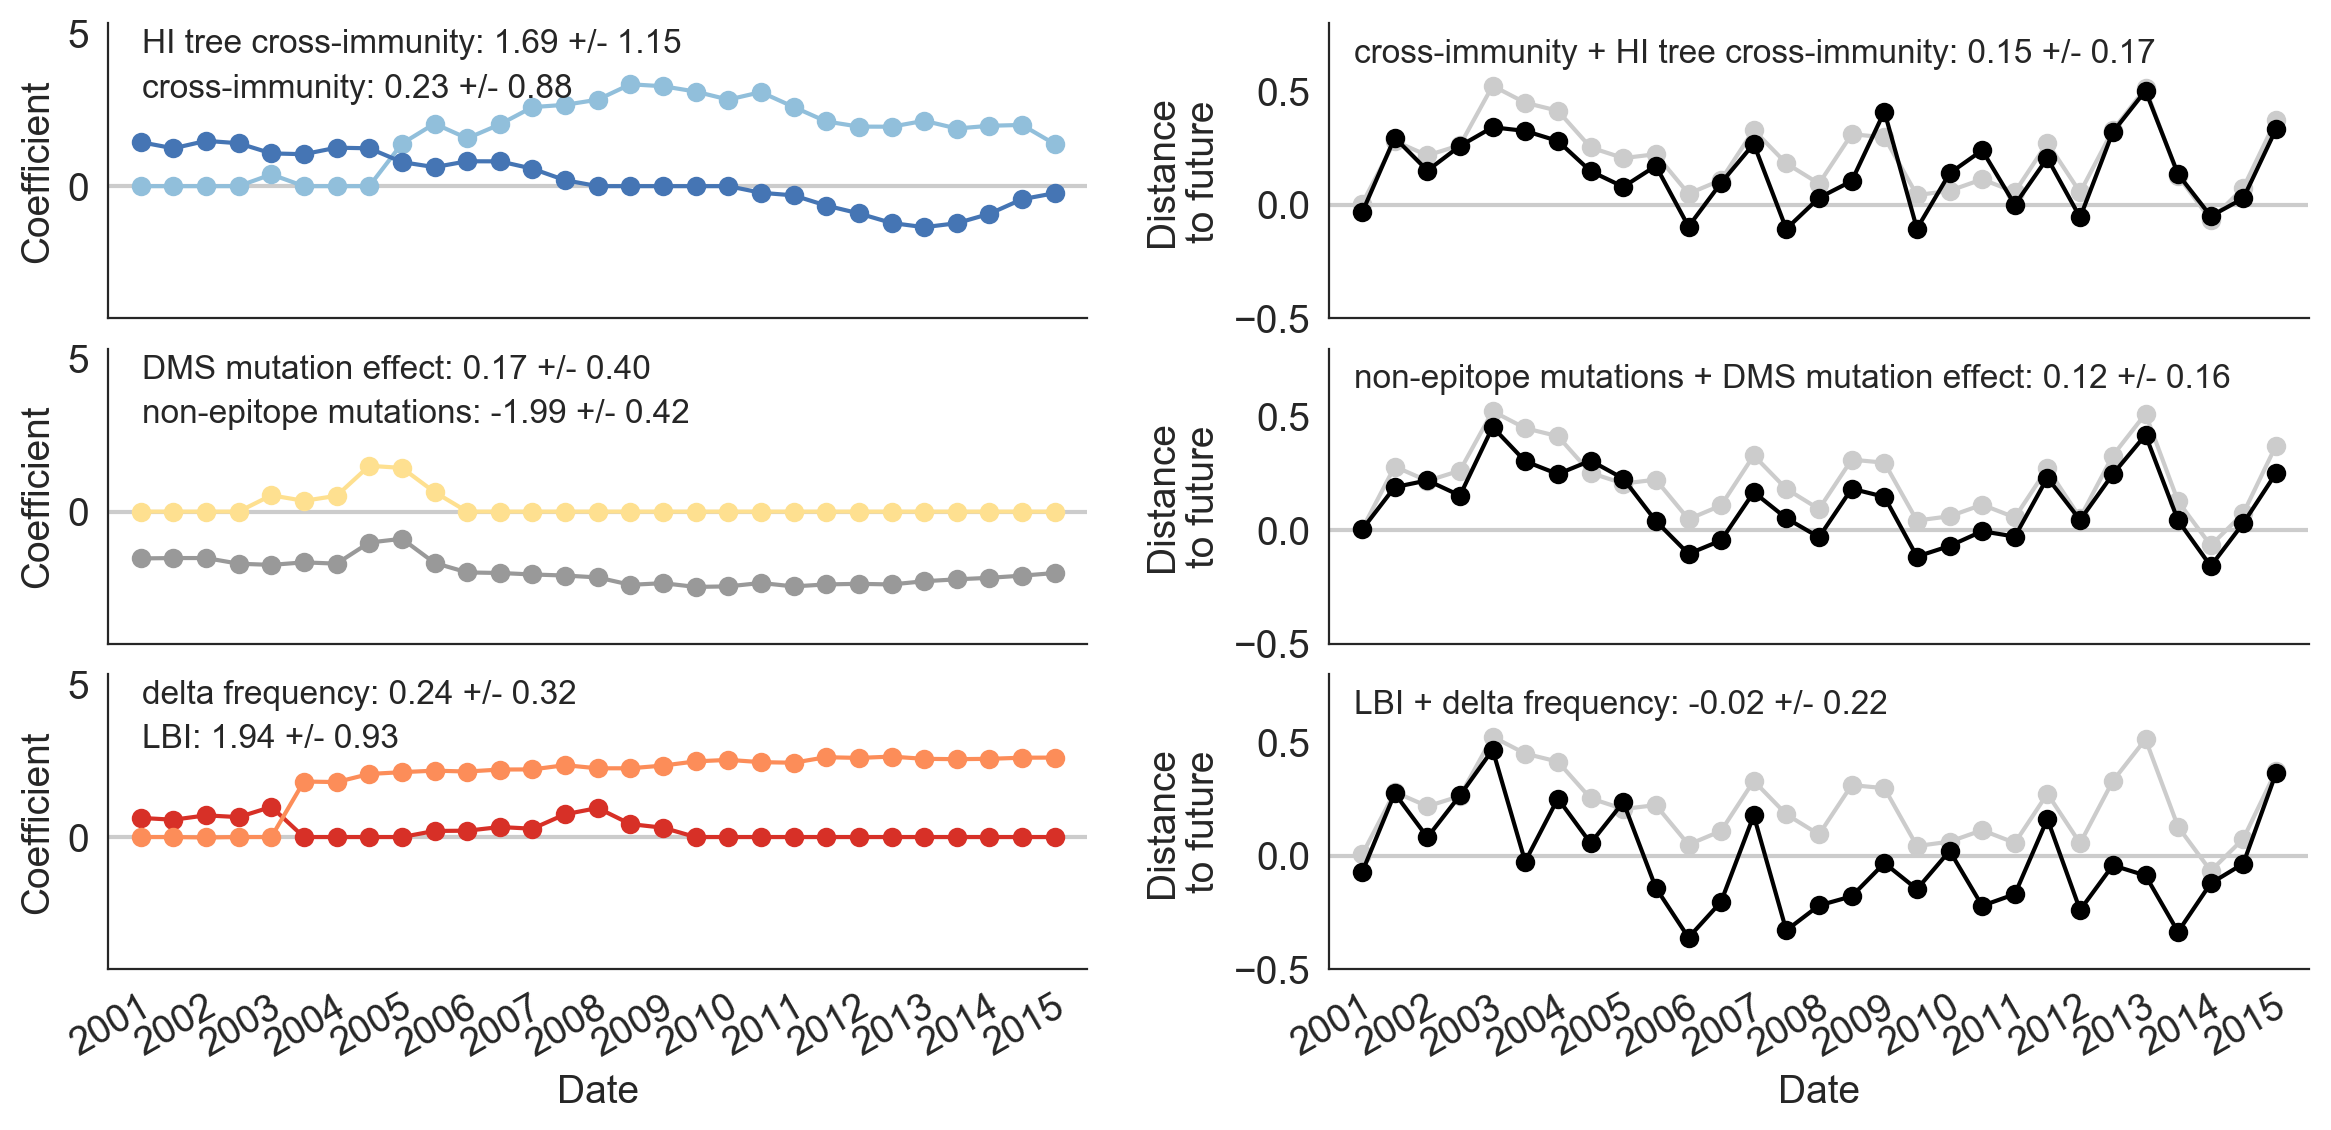

In [48]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best two-metric composite models

In [49]:
best_two_metric_model = [
    "cTiter_x-ne_star",
    "lbi-ne_star",
    "delta_frequency-ne_star"
]

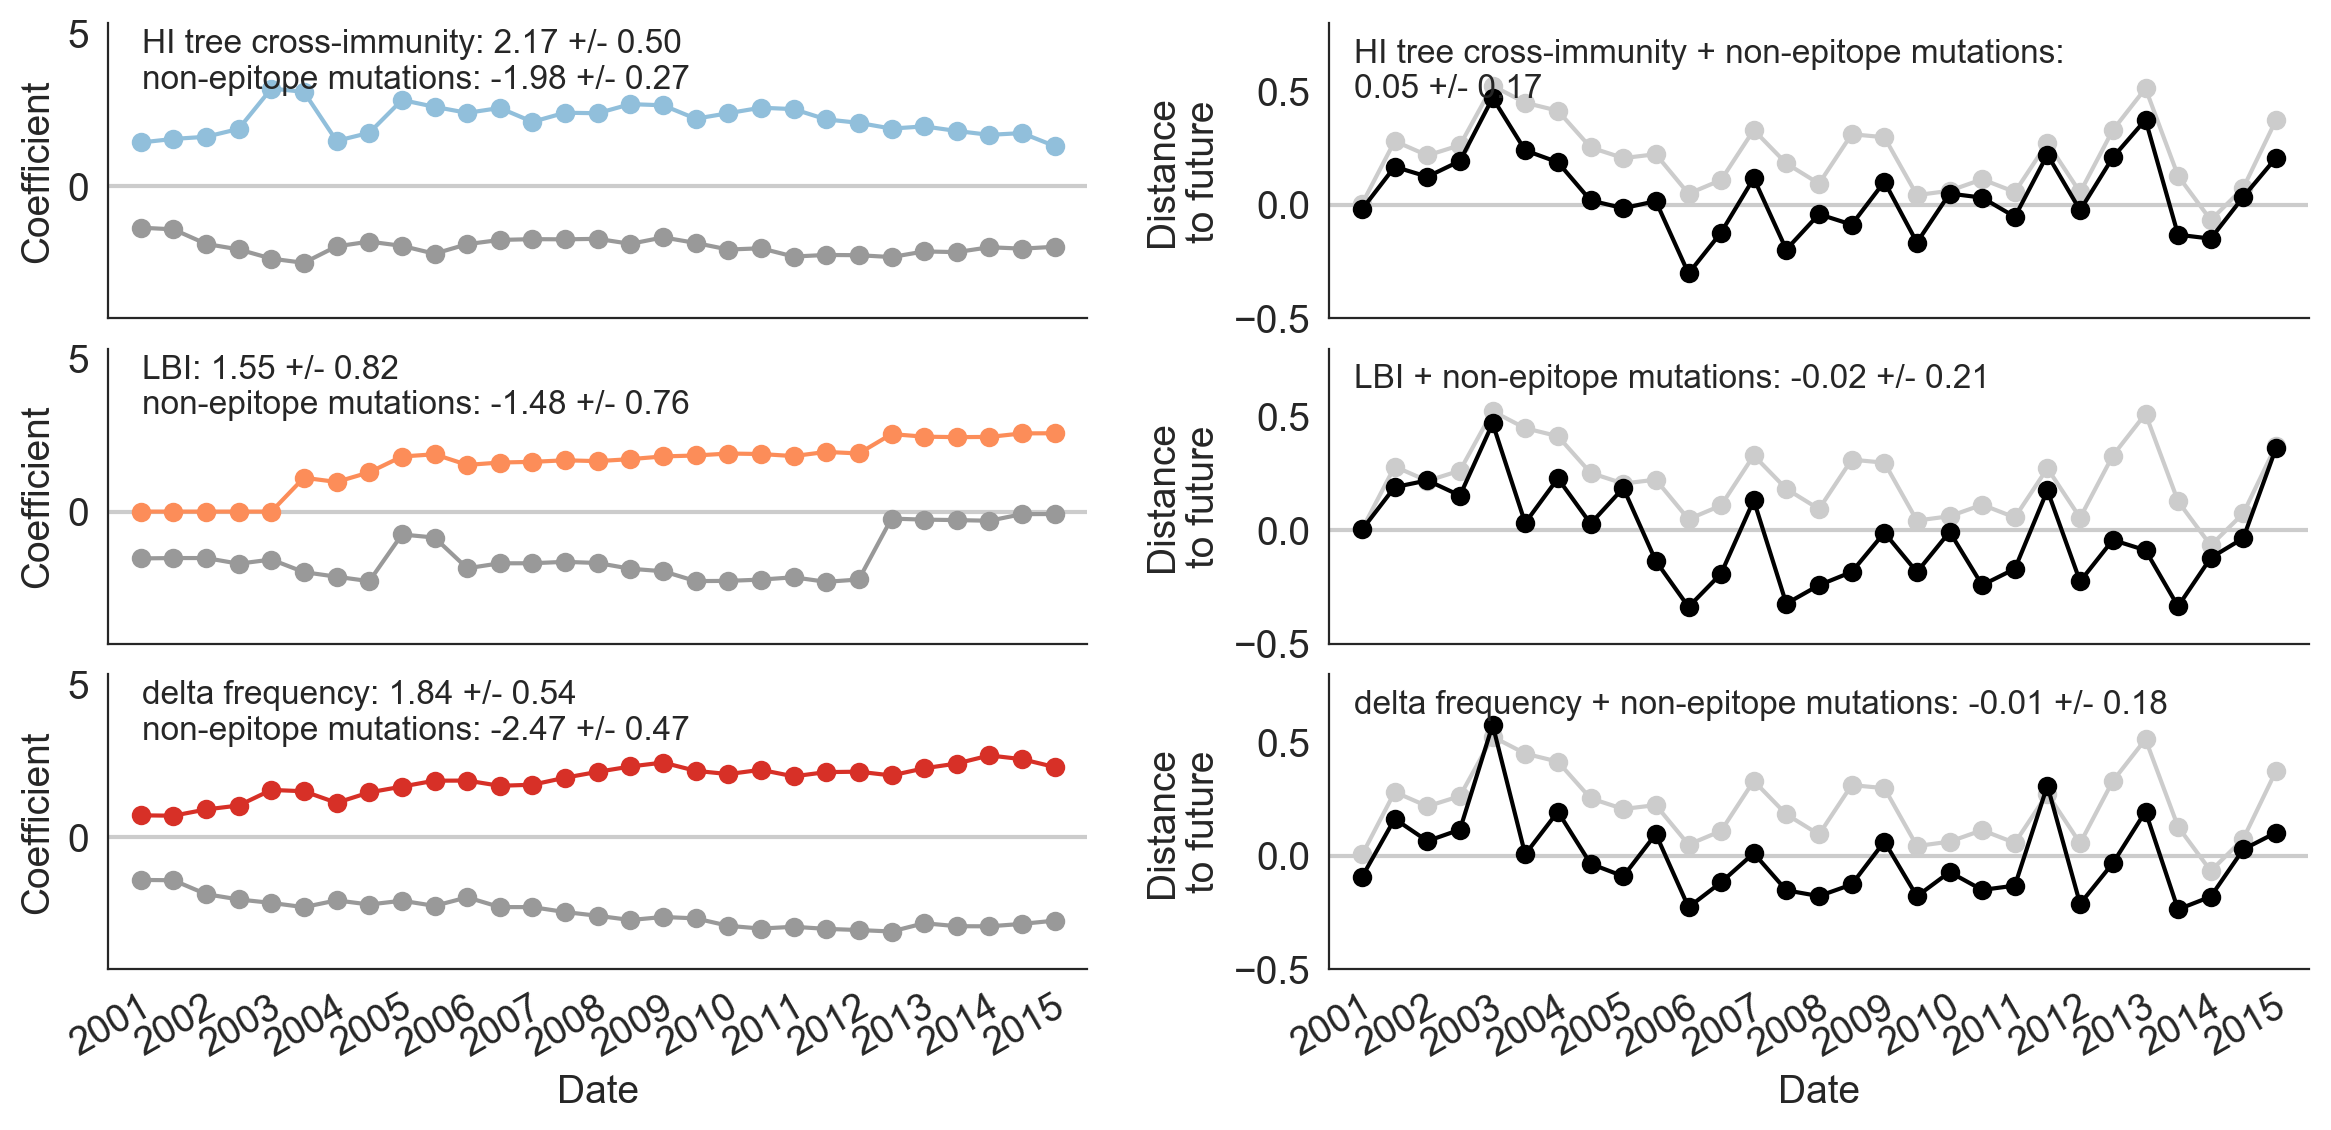

In [50]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_two_metric_model,
    height=6,
    text_vertical_padding=0.12
)
plt.savefig("../manuscript/figures/best-two-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best three-metric composite models

In [51]:
best_three_metric_model = [
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

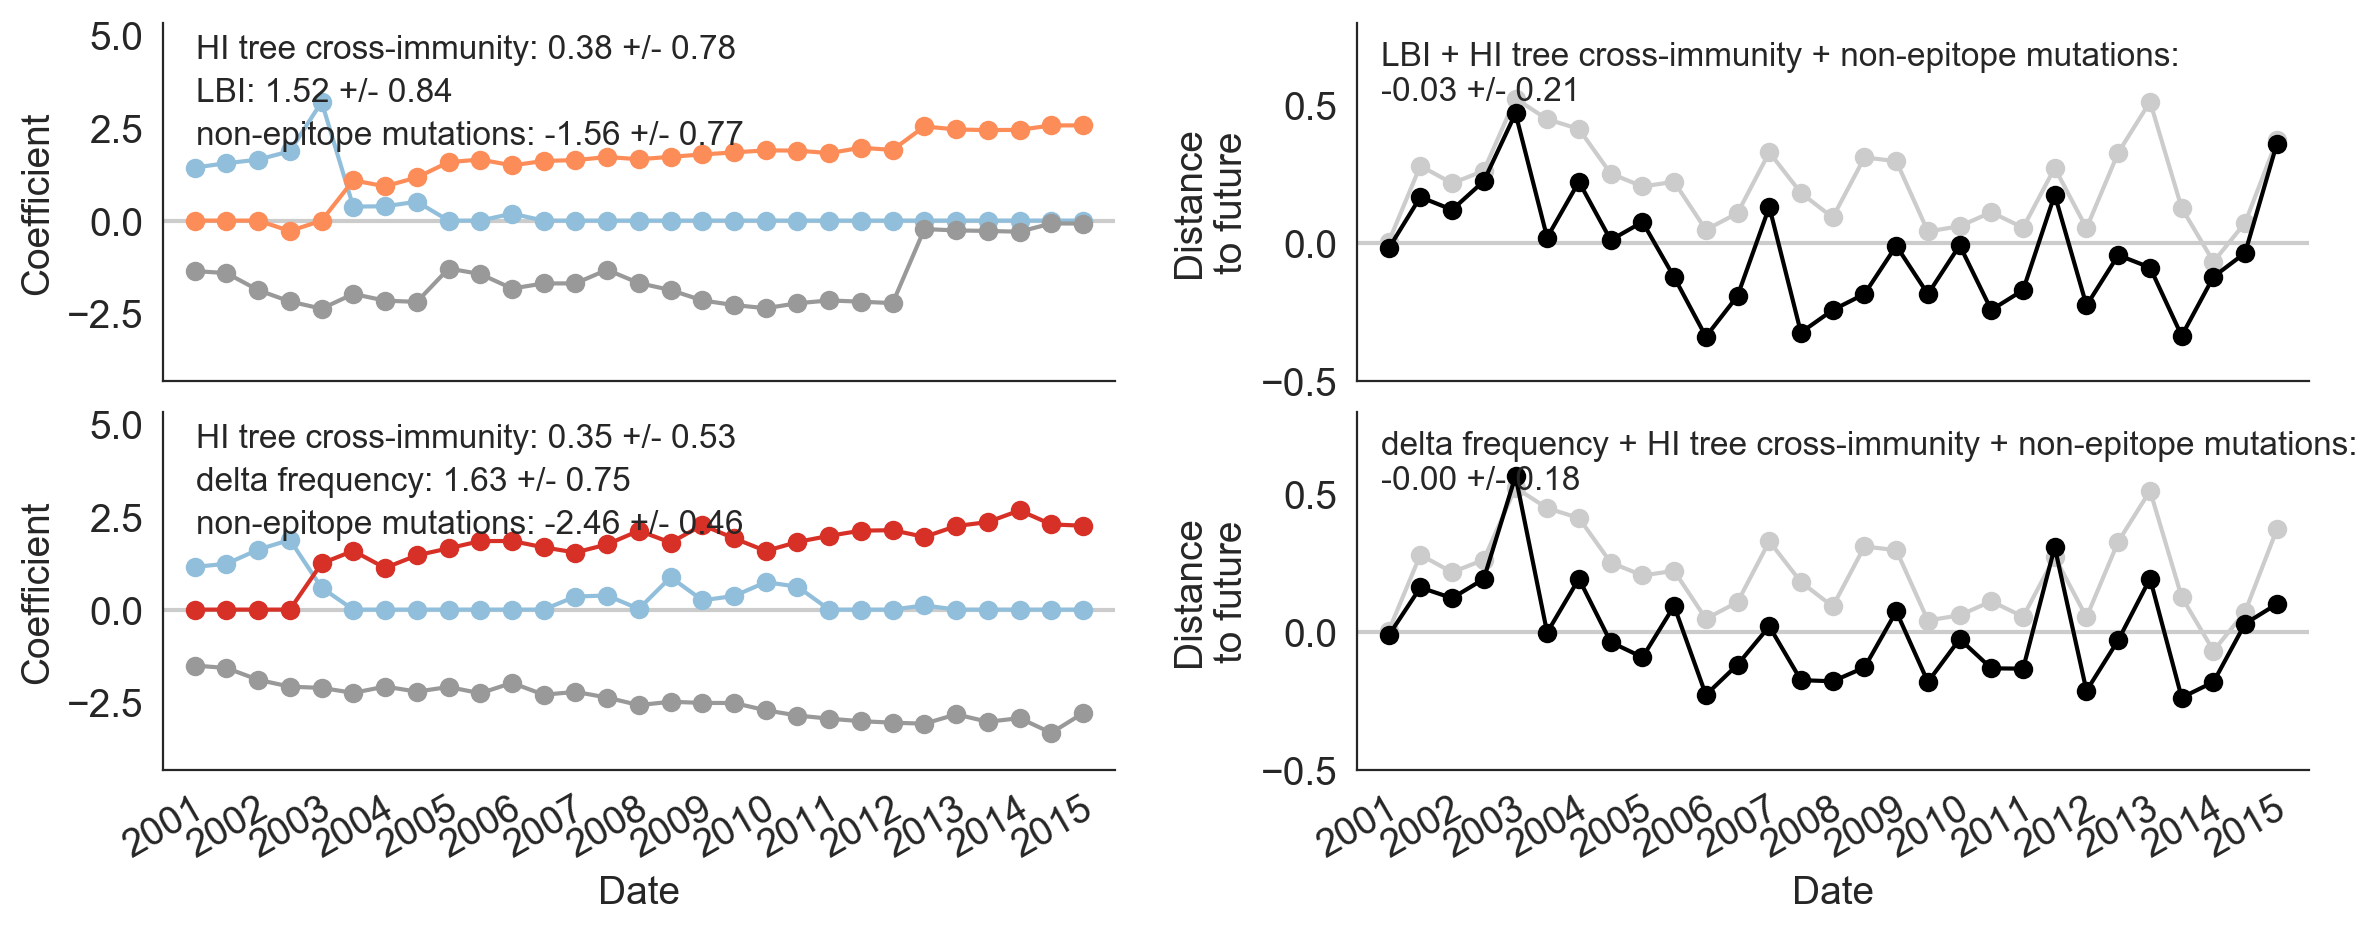

In [52]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_three_metric_model,
    height=5
)
plt.savefig("../manuscript/figures/best-three-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

Calculate sum of differences between the estimated distances from the naive model and each biological model. The higher sum per model, the more the biological model outperforms the naive model.

In [70]:
naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

In [71]:
natural_errors_by_time_with_naive_df = natural_errors_by_time_df.merge(
    naive_error_df,
    on=["validation_timepoint", "validation_n", "type", "sample"],
    suffixes=["_model", "_naive"]
)

In [73]:
natural_errors_by_time_with_naive_df["model_gain"] = (
    natural_errors_by_time_with_naive_df["validation_error_naive"] - natural_errors_by_time_with_naive_df["validation_error_model"]
)

In [74]:
natural_errors_by_time_with_naive_df.head()

predictors_model  validation_error_model  validation_n validation_timepoint  \
0            naive                0.004791           211           2000-10-01   
1               ep               -0.012228           211           2000-10-01   
2          ep_wolf                0.003726           211           2000-10-01   
3             ep_x               -0.034130           211           2000-10-01   
4               rb                0.004403           211           2000-10-01   

      type                                sample predictors_naive  \
0  natural  natural_sample_0_with_90_vpm_sliding            naive   
1  natural  natural_sample_0_with_90_vpm_sliding            naive   
2  natural  natural_sample_0_with_90_vpm_sliding            naive   
3  natural  natural_sample_0_with_90_vpm_sliding            naive   
4  natural  natural_sample_0_with_90_vpm_sliding            naive   

   validation_error_naive  model_gain  
0                0.004791    0.000000  
1                0.004791    0.017018  
2                0.004791    0.001064  
3                0.004791    0.038921  
4                0.004791    0.000387

In [75]:
natural_errors_by_time_with_naive_df.groupby("predictors_model")["model_gain"].sum().sort_values(ascending=False)

predictors_model
lbi-cTiter-ne_star                  7.071511
lbi-cTiter_x-ne_star                7.056548
lbi-ne_star                         6.855285
lbi-delta_frequency                 6.770054
lbi-ep_x-ne_star                    6.645752
delta_frequency-cTiter-ne_star      6.601739
lbi                                 6.494087
delta_frequency-ne_star             6.458615
delta_frequency-cTiter_x-ne_star    6.178926
cTiter_x-ne_star                    4.706164
cTiter-ne_star                      4.499005
ne_star                             2.952911
ne_star-dms_star                    2.748538
delta_frequency                     2.709320
ep_x-ne_star                        2.544407
cTiter_x                            2.150582
cTiter                              2.015778
ep_x-cTiter_x                       1.738015
dms_nonepitope                      0.786989
ep-cTiter                           0.446907
dms_star                            0.063414
naive                               0.

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")